In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt
import numpy as np


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


In [2]:
import math

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

#y_old = df[[OLD_VAR]].values.flatten().astype(float)
#y_test_old = y[-ntest:]

In [4]:
SEED = 98
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [35]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


# Cuffed model

In [11]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [12]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.5;, score=0.877 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=1;, score=0.878 total time=   0.4s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.881 total time=   0.8s
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.880 total time=   2.2s
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.883 total time=   2.9s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=1;, score=0.880 total time=   0.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=1;, score=0.874 total time=   1.3s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, 

In [14]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-cuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Uncuffed model

In [15]:
train_mask = (x_train[:,4] == 0)
test_mask = (x_test[:,4] == 0)

x_train_c = x_train[train_mask][:,0:4]
y_train_c = y_train[train_mask]
x_test_c = x_test[test_mask][:,0:4]
y_test_c = y_test[test_mask]

In [16]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                    n_jobs=-1,
                    verbose=3,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_c, y_train_c)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_c).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_c)
acc3 = np.mean((y_pred >= y_test_c-0.5) & (y_pred <= y_test_c+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.877 total time=   2.2s
[CV 5/5] END colsample_bytree=0.5, max_depth=4, n_estimators=300, subsample=1;, score=0.875 total time=   2.9s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=25, subsample=0.8;, score=0.877 total time=   0.5s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=50, subsample=0.8;, score=0.882 total time=   0.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=0.5;, score=0.873 total time=   1.8s
[CV 5/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=1;, score=0.866 total time=   4.9s
[CV 3/5] END colsample_bytree=0.8, max_depth=4, n_estimators=75, subsample=0.5;, score=0.885 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, max_depth

In [17]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR-uncuffed_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test_c, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test_c, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test_c, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test_c, y_pred):.3f}')
f.close()

# Cuffed + Uncuffed

## Age-based (Cole)

In [ ]:
# age-based formula - Cole's formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

In [8]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.272
mean_absolute_errors: 0.395
r2_score: 0.725
acc: 0.344
acc(+-0.5mm): 0.878


In [ ]:
# Khine
{0: 3.0, 1:3.5, 2: 3.5, 3: 4, 4: 4}

### age 내림으로 수정

In [59]:
[math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(0,6)]

[3.5, 4, 4.5, 4.5, 5.0, 5.0]

In [52]:
import math
df_cole = pd.DataFrame({'age_cal':x_test[:,0], 'cuffed':x_test[:,4]})
df_cole['age'] = df_cole['age_cal'].apply(lambda x: math.floor(x))

OLD_VAR = 'old_tube_size'
df_cole[OLD_VAR] = df_cole['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df_cole[OLD_VAR] = df_cole.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df_cole[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.817
mean_squared_errors: 0.321
mean_absolute_errors: 0.449
r2_score: 0.676
acc: 0.276
acc(+-0.5mm): 0.841


In [61]:
cuff_mask = x_test[:,4] == 1

y_test_old1 = y_test_old[cuff_mask]
y_test1 = y_test[cuff_mask]

print('--------------')
print('old model for cuffed = age/4+3.5')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model for cuffed = age/4+3.5
--------------
explained_variance_score: 0.873
mean_squared_errors: 0.302
mean_absolute_errors: 0.419
r2_score: 0.728
acc: 0.318
acc(+-0.5mm): 0.870


In [63]:
cuff_mask = x_test[:,4] == 1

y_test_old1 = y_test_old[~cuff_mask]
y_test1 = y_test[~cuff_mask]

print('--------------')
print('old model for uncuffed = age/4+3.5')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model for uncuffed = age/4+3.5
--------------
explained_variance_score: 0.791
mean_squared_errors: 0.328
mean_absolute_errors: 0.461
r2_score: 0.649
acc: 0.259
acc(+-0.5mm): 0.829


In [53]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        #cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
#cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('old_내림.png')
plt.close()

## XGBR

In [9]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 2/5] END colsample_bytree=0.5, max_depth=3, n_estimators=50, subsample=0.5;, score=0.881 total time=   0.7s
[CV 4/5] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=0.8;, score=0.877 total time=   2.5s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.8;, score=0.881 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=50, subsample=1;, score=0.878 total time=   0.7s
[CV 5/5] END colsample_bytree=0.5, max_depth=5, n_estimators=100, subsample=0.5;, score=0.875 total time=   2.3s
[CV 3/5] END colsample_bytree=0.5, max_depth=7, n_estimators=75, subsample=0.5;, score=0.878 total time=   1.5s
[CV 1/5] END colsample_bytree=0.5, max_depth=7, n_estimators=100, subsample=1;, score=0.873 total time=   2.1s
[CV 2/5] END colsample_bytree=0.8, max_

In [10]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

### feature importance

In [4]:
# xgbr에 내장된 함수 이용
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

index_list = ['age', 'sex', 'weight', 'height', 'cuffed'] # xgbr.get_booster().feature_names
df_imp = pd.DataFrame({'imp':xgbr.feature_importances_}, index = index_list)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 5


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


,imp
sex,0.002337
height,0.025891
weight,0.056897
cuffed,0.098848
age,0.816028


In [7]:
sys.path

['/home/painstudy/dl_ETT',
 '/home/painstudy/anaconda3/envs/keras/lib/python38.zip',
 '/home/painstudy/anaconda3/envs/keras/lib/python3.8',
 '/home/painstudy/anaconda3/envs/keras/lib/python3.8/lib-dynload',
 '',
 '/home/painstudy/.local/lib/python3.8/site-packages',
 '/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages',
 '/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/IPython/extensions',
 '/home/painstudy/.ipython',
 '/home/painstudy/anaconda3/lib/python3.9/site-packages']

In [8]:
import sys

# 모듈 yaml이 설치된 path를 지정
sys.path.append('/home/painstudy/anaconda3/lib/python3.9/site-packages')
sys.path.append('/home/painstudy/anaconda3/envs/keras/bin/python')

In [9]:
# feature selection using BorutaShap
from BorutaShap import BorutaShap
from sklearn.base import clone

model_BS = clone(model)
Feature_Selector = BorutaShap(model=xgbr, 
                              importance_measure='shap', 
                              classification=False, 
                              percentile=100, 
                              pvalue=0.05)

Feature_Selector.fit(X=X_train, 
                     y=y_train, 
                     n_trials=100, 
                     sample=False, 
                     train_or_test = 'train', 
                     normalize=True, 
                     verbose=False, 
                     random_state=SEED)

# boruta plot
Feature_Selector.plot(X_size=15,
                       which_features='all')

ImportError: Numba could not be imported.
If you are seeing this message and are undertaking Numba development work, you may need to re-run:

python setup.py build_ext --inplace

(Also, please check the development set up guide https://numba.pydata.org/numba-doc/latest/developer/contributing.html.)

If you are not working on Numba development:

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!

The original error was: 'cannot import name '_typeconv' from 'numba.core.typeconv' (/home/painstudy/anaconda3/lib/python3.9/site-packages/numba/core/typeconv/__init__.py)'
--------------------------------------------------------------------------------
If possible please include the following in your error report:

sys.executable: /home/painstudy/anaconda3/envs/keras/bin/python


### < 1 years (new born + infant)

In [13]:
inf_mask = x_train[:,0] < 1
x_train_inf = x_train[inf_mask]
y_train_inf = y_train[inf_mask]

inf_mask = x_test[:,0] < 1
x_test_inf = x_test[inf_mask]
y_test_inf = y_test[inf_mask]

In [14]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_inf, y_train_inf)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_inf).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_inf, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_inf, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_inf, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_inf, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_inf)
acc3 = np.mean((y_pred >= y_test_inf-0.5) & (y_pred <= y_test_inf+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 25, 'subsample': 0.8}
0.586124199643337
--------------
new model
--------------
explained_variance_score: 0.504
mean_squared_errors: 0.122
mean_absolute_errors: 0.196
r2_score: 0.502
acc: 0.642
acc(+-0.5mm): 0.975
[CV 3/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.583 total time=   0.9s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.5;, score=0.560 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.5;, score=0.595 total time=   0.3s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=0.8;, score=0.563 total time=   0.8s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=75, subsample=1;, score=0.563 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=4, n_es

### 1 <= age <= 6 years (Toddler, )

In [21]:
age_mask = (1 <= x_train[:,0]) & (x_train[:,0] < 7)
x_train_age = x_train[age_mask]
y_train_age = y_train[age_mask]

age_mask = (1 <= x_test[:,0]) & (x_test[:,0] < 7)
x_test_age = x_test[age_mask]
y_test_age = y_test[age_mask]

In [22]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_age, y_train_age)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_age).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV 5/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.723 total time=   1.0s
[CV 2/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.8;, score=0.688 total time=   0.4s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.696 total time=   0.5s
[CV 8/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.5;, score=0.698 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=0.8;, score=0.690 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=25, subsample=1;, score=0.697 total time=   0.2s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.5;, score=0.697 total time=   0.3s
[CV 10/10] END colsample_bytree=0.5, max_depth=4, n_estimators=50, subsample=0.8;, score=0.696 total time=   0.3s
[CV 10/10] END colsample_by

In [23]:
print('--------------')
print('new model 1<=age<=6 years')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model 1<=age<=6 years
--------------
explained_variance_score: 0.673
mean_squared_errors: 0.141
mean_absolute_errors: 0.226
r2_score: 0.673
acc: 0.592
acc(+-0.5mm): 0.961


### 6 < age < 10

In [25]:
age_mask = (6 < x_train[:,0])
x_train_age = x_train[age_mask]
y_train_age = y_train[age_mask]

age_mask = (6 < x_test[:,0])
x_test_age = x_test[age_mask]
y_test_age = y_test[age_mask]

In [26]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.01, 0.03, 0.05, 0.07] #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=3,
                param_grid=param_dict, cv=nfold)
gs.fit(x_train_age, y_train_age)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_age).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model 6<age<10')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test_age, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test_age, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test_age, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test_age, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test_age)
acc3 = np.mean((y_pred >= y_test_age-0.5) & (y_pred <= y_test_age+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

========= found hyperparameter =========
{'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 25, 'subsample': 1}
0.36741212303996496
--------------
new model 6<age<10
--------------
explained_variance_score: 0.305
mean_squared_errors: 0.147
mean_absolute_errors: 0.233
r2_score: 0.304
acc: 0.578
acc(+-0.5mm): 0.962


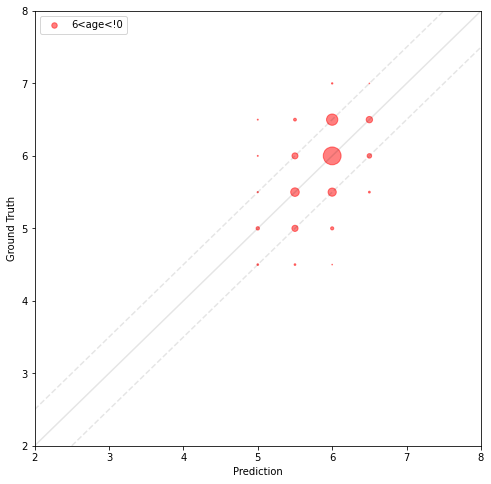

[CV 7/10] END colsample_bytree=0.5, max_depth=3, n_estimators=25, subsample=0.8;, score=0.349 total time=   0.8s
[CV 10/10] END colsample_bytree=0.5, max_depth=3, n_estimators=75, subsample=0.8;, score=0.394 total time=   0.2s
[CV 9/10] END colsample_bytree=0.5, max_depth=3, n_estimators=100, subsample=0.8;, score=0.306 total time=   0.2s
[CV 8/10] END colsample_bytree=0.5, max_depth=3, n_estimators=300, subsample=1;, score=0.339 total time=   0.6s
[CV 4/10] END colsample_bytree=0.5, max_depth=4, n_estimators=75, subsample=1;, score=0.334 total time=   0.2s
[CV 8/10] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.8;, score=0.345 total time=   0.3s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.5;, score=0.350 total time=   0.1s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=0.8;, score=0.347 total time=   0.1s
[CV 5/10] END colsample_bytree=0.5, max_depth=5, n_estimators=25, subsample=1;, score=0.354 tota

In [27]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test_age == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals, label='6<age<!0')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)

## RF

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [32]:
from sklearn.ensemble import RandomForestRegressor

SEED = 98
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 10
gs = GridSearchCV(estimator=RandomForestRegressor(random_state = SEED),
                    n_jobs=-1,
                    verbose=5,
                    param_grid=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.872 total time=   6.7s
[CV 10/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=50;, score=0.870 total time=   5.1s
[CV 9/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.873 total time=  19.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.874 total time=  30.3s
[CV 8/10] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=200;, score=0.873 total time=  20.0s
[CV 3/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=0.875 total time=   5.0s
[CV 4/10] END bootstrap=True, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estim

In [33]:
print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_RF_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
#model.save_model(f'{odir}/model.model')
pickle.dump(gs, open(f'{odir}/gridSearch','wb'))

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

--------------
new model
--------------
explained_variance_score: 0.860
mean_squared_errors: 0.139
mean_absolute_errors: 0.224
r2_score: 0.860
acc: 0.595
acc(+-0.5mm): 0.963


## DNN

In [1]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [2]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
#y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(pd.DataFrame(x_train))
x_test = sc.transform(pd.DataFrame(x_test))

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df.loc[:ntrain-1,INPUT_VARS])
x_test = sc.transform(df.loc[ntrain:,INPUT_VARS])

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [5]:
# folder
nfold = 10  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"result/size/DNN_size_both_y"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: DNN 2 layers, regression')
f.write(f'input: age, sex, height, weight, cuffed 유무  output: tube size')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters pool
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [16, 32, 64, 128, 256, 512]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
dnodes, dropouts = [], []
for i in range(2):
    dnodes.append(0)
    dropouts.append(0)


for dnode1 in dense_opts:
    for dropout1 in dropout_opts:
        for dnode2 in dense_opts:
            for dropout2 in dropout_opts:
                for batch_size in BATCH_SIZE:
                    for learning_rate in lr_opts:
                        test_settings.append([dnode1, dropout1, dnode2, dropout2, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-02-18 10:59:01.424856


In [ ]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    nlayer = random.choice([1,2]) 
    # test settings
    dnodes[0], dropouts[0], dnodes[1], dropouts[1], batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(nlayer):
        odir_f += f'dnodes{dnodes[i]}_dropout{dropouts[i]},'
    odir_f += f'lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)


    # build a model
    inp = Input(shape=(x_train.shape[1],))
    out = inp

    
    for i in range(nlayer):      
        out = Dense(dnodes[i], activation='relu')(out)
        out = Dropout(dropouts[i])(out)
    
    out = Dense(1)(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    acc1s, acc3s, maes = [], [], []

    switch = 0
    for fold, (train_mask, test_mask) in enumerate(kfold.split(y_train)):
        X_train = x_train_imputed[train_mask]
        X_test = x_train_imputed[test_mask] 
        
        Y_train = y_train[train_mask] 
        Y_test = y_train[test_mask]


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=[])
            hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten() 
            y_pred = np.round(y_pred * 2) / 2
            
            acc1 = np.mean(y_pred==Y_test)
            acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
            mae = mean_absolute_error(Y_test, y_pred)           
            
            acc1s.append(acc1)
            acc3s.append(acc3)
            maes.append(mae)

            print(f' ###{fold} fold : val acc1 {acc1:.3f}, acc3 {acc3:.3f}, mae {mae:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue
    

    print(f'acc1{np.mean(acc1s):.3f}_acc3{np.mean(acc3s):.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/acc1-{np.mean(acc1s):.3f}_acc3-{np.mean(acc3s):.3f}_{odir_f}')
    tf.keras.backend.clear_session()

random search 0/500


2023-02-18 10:59:03.711163: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 10:59:04.435367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
609/613 [============================>.] - ETA: 0s - loss: 0.9278
Epoch 00001: val_loss improved from inf to 0.19348, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 4s 4ms/step - loss: 0.9244 - val_loss: 0.1935
Epoch 2/100
605/613 [============================>.] - ETA: 0s - loss: 0.2676
Epoch 00002: val_loss improved from 0.19348 to 0.13977, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2676 - val_loss: 0.1398
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.2599
Epoch 00003: val_loss did not improve from 0.13977
613/613 [==============================] - 2s 4ms/step - loss: 0.2595 - val_loss: 0.1916
Epoch 4/100
605/613 [============================>.] - ETA: 0s - loss: 0.2632
Epoch 00004: val_loss improv

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 0.8756
Epoch 00001: val_loss improved from inf to 0.20557, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8750 - val_loss: 0.2056
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.2763
Epoch 00002: val_loss improved from 0.20557 to 0.13710, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2759 - val_loss: 0.1371
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.2791
Epoch 00003: val_loss did not improve from 0.13710
613/613 [==============================] - 2s 4ms/step - loss: 0.2789 - val_loss: 0.2821
Epoch 4/100
606/613 [============================>.] - ETA: 0s - loss: 0.2498
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 0.8660
Epoch 00001: val_loss improved from inf to 0.20387, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8660 - val_loss: 0.2039
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.2742
Epoch 00002: val_loss improved from 0.20387 to 0.14028, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2740 - val_loss: 0.1403
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.2838
Epoch 00003: val_loss did not improve from 0.14028
613/613 [==============================] - 2s 4ms/step - loss: 0.2842 - val_loss: 0.3150
Epoch 4/100
611/613 [============================>.] - ETA: 0s - loss: 0.2604
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 0.8958
Epoch 00001: val_loss improved from inf to 0.18587, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.8830 - val_loss: 0.1859
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.2737
Epoch 00002: val_loss improved from 0.18587 to 0.14256, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2729 - val_loss: 0.1426
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.3089
Epoch 00003: val_loss did not improve from 0.14256
613/613 [==============================] - 2s 3ms/step - loss: 0.3089 - val_loss: 0.2841
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.2555
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 0.9150
Epoch 00001: val_loss improved from inf to 0.17072, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.9150 - val_loss: 0.1707
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.2974
Epoch 00002: val_loss improved from 0.17072 to 0.15626, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2973 - val_loss: 0.1563
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.3098
Epoch 00003: val_loss improved from 0.15626 to 0.15126, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3090 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 0.5446
Epoch 00001: val_loss improved from inf to 0.20312, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.5436 - val_loss: 0.2031
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.2506
Epoch 00002: val_loss improved from 0.20312 to 0.17047, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2505 - val_loss: 0.1705
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.2181
Epoch 00003: val_loss improved from 0.17047 to 0.14858, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2179 - val_loss: 0.1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


609/613 [============================>.] - ETA: 0s - loss: 1.1688
Epoch 00001: val_loss improved from inf to 0.14863, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1633 - val_loss: 0.1486
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.2978
Epoch 00002: val_loss did not improve from 0.14863
613/613 [==============================] - 2s 4ms/step - loss: 0.2978 - val_loss: 0.1860
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.2587
Epoch 00003: val_loss improved from 0.14863 to 0.14522, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2577 - val_loss: 0.1452
Epoch 4/100
612/613 [============================>.] - ETA: 0s - loss: 0.2847
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 1.1516
Epoch 00001: val_loss improved from inf to 0.15978, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1346 - val_loss: 0.1598
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.3361
Epoch 00002: val_loss did not improve from 0.15978
613/613 [==============================] - 2s 4ms/step - loss: 0.3354 - val_loss: 0.1656
Epoch 3/100
601/613 [============================>.] - ETA: 0s - loss: 0.3062
Epoch 00003: val_loss improved from 0.15978 to 0.14360, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3046 - val_loss: 0.1436
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.3030
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 1.1416
Epoch 00001: val_loss improved from inf to 0.15102, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1416 - val_loss: 0.1510
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.3356
Epoch 00002: val_loss did not improve from 0.15102
613/613 [==============================] - 2s 4ms/step - loss: 0.3348 - val_loss: 0.1543
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.3109
Epoch 00003: val_loss improved from 0.15102 to 0.14850, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3098 - val_loss: 0.1485
Epoch 4/100
607/613 [============================>.] - ETA: 0s - loss: 0.3055
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 1.1428
Epoch 00001: val_loss improved from inf to 0.14796, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 1.1416 - val_loss: 0.1480
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.3350
Epoch 00002: val_loss did not improve from 0.14796
613/613 [==============================] - 2s 4ms/step - loss: 0.3348 - val_loss: 0.1540
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.3098
Epoch 00003: val_loss improved from 0.14796 to 0.14688, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.4,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.3098 - val_loss: 0.1469
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.3061
Epoch 00004: val_loss did not improve fr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


65/77 [========================>.....] - ETA: 0s - loss: 19.2984
Epoch 00001: val_loss improved from inf to 13.59509, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5708 - val_loss: 13.5951
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 10.5923
Epoch 00002: val_loss improved from 13.59509 to 6.51969, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0363 - val_loss: 6.5197
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 4.8782
Epoch 00003: val_loss improved from 6.51969 to 2.76211, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.7532 - val_loss: 2.7621
Epoch 4/100
62/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 18.9252
Epoch 00001: val_loss improved from inf to 13.58276, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 18.5561 - val_loss: 13.5828
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.3997
Epoch 00002: val_loss improved from 13.58276 to 6.51094, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0374 - val_loss: 6.5109
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 4.8014
Epoch 00003: val_loss improved from 6.51094 to 2.75632, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7617 - val_loss: 2.7563
Epoch 4/100
64/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
66/77 [========================>.....] - ETA: 0s - loss: 19.2794
Epoch 00001: val_loss improved from inf to 13.57704, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5766 - val_loss: 13.5770
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 10.4306
Epoch 00002: val_loss improved from 13.57704 to 6.51213, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0256 - val_loss: 6.5121
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.8058
Epoch 00003: val_loss improved from 6.51213 to 2.75964, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7449 - val_loss: 2.7596
Epoch 4/100
65/77 [========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.2071
Epoch 00001: val_loss improved from inf to 13.59920, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5740 - val_loss: 13.5992
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 10.2361
Epoch 00002: val_loss improved from 13.59920 to 6.52496, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0392 - val_loss: 6.5250
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.8193
Epoch 00003: val_loss improved from 6.52496 to 2.76727, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.7580 - val_loss: 2.7673
Epoch 4/100
64/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 19.1370
Epoch 00001: val_loss improved from inf to 13.62650, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5864 - val_loss: 13.6265
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.5958
Epoch 00002: val_loss improved from 13.62650 to 6.56603, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.1806 - val_loss: 6.5660
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 5.3245
Epoch 00003: val_loss improved from 6.56603 to 2.93432, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.0215 - val_loss: 2.9343
Epoch 4/100
59/77 [=====================>........] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 19.0090
Epoch 00001: val_loss improved from inf to 13.47621, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5166 - val_loss: 13.4762
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1652
Epoch 00002: val_loss improved from 13.47621 to 6.26303, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.7668 - val_loss: 6.2630
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 4.6294
Epoch 00003: val_loss improved from 6.26303 to 2.72390, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.4389 - val_loss: 2.7239
Epoch 4/100
64/77 [=======================>......] - ETA: 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/77 [======================>.......] - ETA: 0s - loss: 19.5526
Epoch 00001: val_loss improved from inf to 13.48230, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 18.5092 - val_loss: 13.4823
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 10.4086
Epoch 00002: val_loss improved from 13.48230 to 6.32192, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9932 - val_loss: 6.3219
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 5.2128
Epoch 00003: val_loss improved from 6.32192 to 2.90692, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.8909 - val_loss: 2.9069
Epoch 4/100
75/77 [============================>.] - ETA: 0

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.1366
Epoch 00001: val_loss improved from inf to 13.50595, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5085 - val_loss: 13.5059
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1419
Epoch 00002: val_loss improved from 13.50595 to 6.32988, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0093 - val_loss: 6.3299
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 5.0922
Epoch 00003: val_loss improved from 6.32988 to 2.90187, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8839 - val_loss: 2.9019
Epoch 4/100
67/77 [=========================>....] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 19.0711
Epoch 00001: val_loss improved from inf to 13.57709, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5040 - val_loss: 13.5771
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 10.0093
Epoch 00002: val_loss improved from 13.57709 to 6.39765, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0119 - val_loss: 6.3977
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 5.1391
Epoch 00003: val_loss improved from 6.39765 to 2.94436, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8849 - val_loss: 2.9444
Epoch 4/100
61/77 [======================>.......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 19.1441
Epoch 00001: val_loss improved from inf to 13.59553, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 18.5040 - val_loss: 13.5955
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 10.1395
Epoch 00002: val_loss improved from 13.59553 to 6.39376, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 10.0119 - val_loss: 6.3938
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 5.1391
Epoch 00003: val_loss improved from 6.39376 to 2.94915, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.8849 - val_loss: 2.9491
Epoch 4/100
67/77 [=========================>....] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 2.3059
Epoch 00001: val_loss improved from inf to 0.29873, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2248 - val_loss: 0.2987
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.6961
Epoch 00002: val_loss improved from 0.29873 to 0.23571, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6914 - val_loss: 0.2357
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.4471
Epoch 00003: val_loss did not improve from 0.23571
307/307 [==============================] - 1s 4ms/step - loss: 0.4472 - val_loss: 0.4649
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.3459
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.2612
Epoch 00001: val_loss improved from inf to 0.30472, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2171 - val_loss: 0.3047
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.6851
Epoch 00002: val_loss improved from 0.30472 to 0.23432, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6849 - val_loss: 0.2343
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.3296
Epoch 00003: val_loss did not improve from 0.23432
307/307 [==============================] - 1s 4ms/step - loss: 0.4460 - val_loss: 0.5423
Epoch 4/100
300/307 [============================>.] - ETA: 0s - loss: 0.3456
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 2.2622
Epoch 00001: val_loss improved from inf to 0.31248, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2246 - val_loss: 0.3125
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.6889
Epoch 00002: val_loss improved from 0.31248 to 0.24899, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6779 - val_loss: 0.2490
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.4442
Epoch 00003: val_loss did not improve from 0.24899
307/307 [==============================] - 1s 4ms/step - loss: 0.4442 - val_loss: 0.5783
Epoch 4/100
305/307 [============================>.] - ETA: 0s - loss: 0.3529
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 2.3247
Epoch 00001: val_loss improved from inf to 0.32342, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2558 - val_loss: 0.3234
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.7023
Epoch 00002: val_loss improved from 0.32342 to 0.25477, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6931 - val_loss: 0.2548
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.4390
Epoch 00003: val_loss did not improve from 0.25477
307/307 [==============================] - 1s 4ms/step - loss: 0.4393 - val_loss: 0.5460
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.3419
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.5994
Epoch 00001: val_loss improved from inf to 0.28460, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.5610 - val_loss: 0.2846
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.7323
Epoch 00002: val_loss did not improve from 0.28460
307/307 [==============================] - 1s 4ms/step - loss: 0.7323 - val_loss: 0.3070
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4214
Epoch 00003: val_loss improved from 0.28460 to 0.24682, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4171 - val_loss: 0.2468
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.3716
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 1.9631
Epoch 00001: val_loss improved from inf to 0.28280, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.9456 - val_loss: 0.2828
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.3715
Epoch 00002: val_loss did not improve from 0.28280
307/307 [==============================] - 1s 4ms/step - loss: 0.3712 - val_loss: 0.3349
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.3288
Epoch 00003: val_loss improved from 0.28280 to 0.25377, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3282 - val_loss: 0.2538
Epoch 4/100
302/307 [============================>.] - ETA: 0s - loss: 0.2938
Epoch 00004: val_loss did not improve from

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.8029
Epoch 00001: val_loss improved from inf to 0.28316, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6803 - val_loss: 0.2832
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.7779
Epoch 00002: val_loss improved from 0.28316 to 0.26019, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.7643 - val_loss: 0.2602
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.5137
Epoch 00003: val_loss improved from 0.26019 to 0.25654, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5083 - val_loss: 0.2565

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 3.7680
Epoch 00001: val_loss improved from inf to 0.29138, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6994 - val_loss: 0.2914
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.8563
Epoch 00002: val_loss improved from 0.29138 to 0.28048, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8563 - val_loss: 0.2805
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.5782
Epoch 00003: val_loss improved from 0.28048 to 0.26571, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5723 - val_loss: 0.2657

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 3.7854
Epoch 00001: val_loss improved from inf to 0.29486, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6849 - val_loss: 0.2949
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.8429
Epoch 00002: val_loss improved from 0.29486 to 0.27795, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8284 - val_loss: 0.2780
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.5581
Epoch 00003: val_loss improved from 0.27795 to 0.26602, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5537 - val_loss: 0.2660

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


295/307 [===========================>..] - ETA: 0s - loss: 3.8069
Epoch 00001: val_loss improved from inf to 0.29468, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6849 - val_loss: 0.2947
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.4014
Epoch 00002: val_loss improved from 0.29468 to 0.28426, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8284 - val_loss: 0.2843
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.5616
Epoch 00003: val_loss improved from 0.28426 to 0.27322, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0.3,dnodes128_dropout0.2,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5537 - val_loss: 0.2732

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.2906
Epoch 00001: val_loss improved from inf to 8.68182, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2502 - val_loss: 8.6818
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1274
Epoch 00002: val_loss improved from 8.68182 to 2.63956, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 7.1095 - val_loss: 2.6396
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7076
Epoch 00003: val_loss improved from 2.63956 to 1.23927, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0146 - val_loss: 1.2393
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.4575
Epoch 00001: val_loss improved from inf to 8.66922, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2572 - val_loss: 8.6692
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 7.2538
Epoch 00002: val_loss improved from 8.66922 to 2.63276, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1634 - val_loss: 2.6328
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 3.7019
Epoch 00003: val_loss improved from 2.63276 to 1.23048, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0018 - val_loss: 1.2305
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.3051
Epoch 00001: val_loss improved from inf to 8.66776, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2638 - val_loss: 8.6678
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1801
Epoch 00002: val_loss improved from 8.66776 to 2.65342, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1574 - val_loss: 2.6534
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 4.0358
Epoch 00003: val_loss improved from 2.65342 to 1.24771, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0316 - val_loss: 1.2477
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 15.3009
Epoch 00001: val_loss improved from inf to 8.68099, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.2608 - val_loss: 8.6810
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 7.1727
Epoch 00002: val_loss improved from 8.68099 to 2.66890, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.1498 - val_loss: 2.6689
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7196
Epoch 00003: val_loss improved from 2.66890 to 1.24204, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 4.0213 - val_loss: 1.2420
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.4773
Epoch 00001: val_loss improved from inf to 9.02238, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.4773 - val_loss: 9.0224
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 7.5799
Epoch 00002: val_loss improved from 9.02238 to 2.69405, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.4430 - val_loss: 2.6940
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 4.9056
Epoch 00003: val_loss improved from 2.69405 to 1.34364, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.9056 - val_loss: 1.3436
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 17.4852 
Epoch 00001: val_loss improved from inf to 8.38692, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 14.9323 - val_loss: 8.3869
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1308
Epoch 00002: val_loss improved from 8.38692 to 2.36527, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.1188 - val_loss: 2.3653
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 3.8135
Epoch 00003: val_loss improved from 2.36527 to 1.17219, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.5437 - val_loss: 1.1722
Epoch 4/

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.0202
Epoch 00001: val_loss improved from inf to 8.56435, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0202 - val_loss: 8.5644
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1777
Epoch 00002: val_loss improved from 8.56435 to 2.41351, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5633 - val_loss: 2.4135
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 8.7343
Epoch 00003: val_loss improved from 2.41351 to 1.30823, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.2850 - val_loss: 1.3082
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 15.3584
Epoch 00001: val_loss improved from inf to 8.56687, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0224 - val_loss: 8.5669
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 6.5502
Epoch 00002: val_loss improved from 8.56687 to 2.39059, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5309 - val_loss: 2.3906
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 6.6024
Epoch 00003: val_loss improved from 2.39059 to 1.30556, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3910 - val_loss: 1.3056
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 15.2231
Epoch 00001: val_loss improved from inf to 8.64020, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0257 - val_loss: 8.6402
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 6.5444
Epoch 00002: val_loss improved from 8.64020 to 2.44355, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5444 - val_loss: 2.4435
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 6.3974
Epoch 00003: val_loss improved from 2.44355 to 1.35488, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3704 - val_loss: 1.3549
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 15.0257
Epoch 00001: val_loss improved from inf to 8.65024, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 15.0257 - val_loss: 8.6502
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 7.1395
Epoch 00002: val_loss improved from 8.65024 to 2.44073, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 6.5444 - val_loss: 2.4407
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 6.3974
Epoch 00003: val_loss improved from 2.44073 to 1.34777, saving model to result/size/DNN_size_both_y/batch512,dnodes64_dropout0.5,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 6.3704 - val_loss: 1.3478
Epoch 4/1

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


74/77 [===========================>..] - ETA: 0s - loss: 14.3561
Epoch 00001: val_loss improved from inf to 5.99854, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0817 - val_loss: 5.9985
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 3.4001
Epoch 00002: val_loss improved from 5.99854 to 1.28397, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1763 - val_loss: 1.2840
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.8492
Epoch 00003: val_loss improved from 1.28397 to 0.56727, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0933 - val_loss: 0.5673
Epoch 4/100
73/77 [===========================>..] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 15.4660
Epoch 00001: val_loss improved from inf to 5.99433, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.0777 - val_loss: 5.9943
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 3.5419
Epoch 00002: val_loss improved from 5.99433 to 1.28372, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.1940 - val_loss: 1.2837
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 0.8794
Epoch 00003: val_loss improved from 1.28372 to 0.56599, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1000 - val_loss: 0.5660
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 15.0138
Epoch 00001: val_loss improved from inf to 5.98259, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0752 - val_loss: 5.9826
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 3.4365
Epoch 00002: val_loss improved from 5.98259 to 1.28672, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1818 - val_loss: 1.2867
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 0.8984
Epoch 00003: val_loss improved from 1.28672 to 0.56612, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1002 - val_loss: 0.5661
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


72/77 [===========================>..] - ETA: 0s - loss: 14.5622
Epoch 00001: val_loss improved from inf to 6.00690, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 14.0756 - val_loss: 6.0069
Epoch 2/100
72/77 [===========================>..] - ETA: 0s - loss: 3.3128
Epoch 00002: val_loss improved from 6.00690 to 1.28855, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1968 - val_loss: 1.2886
Epoch 3/100
75/77 [============================>.] - ETA: 0s - loss: 0.8492
Epoch 00003: val_loss improved from 1.28855 to 0.56741, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0984 - val_loss: 0.5674
Epoch 4/100
77/77 [==============================] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 14.9715
Epoch 00001: val_loss improved from inf to 6.03597, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 14.0630 - val_loss: 6.0360
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 3.3954
Epoch 00002: val_loss improved from 6.03597 to 1.27325, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2180 - val_loss: 1.2732
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 1.1395
Epoch 00003: val_loss improved from 1.27325 to 0.55692, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.0891 - val_loss: 0.5569
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


71/77 [==========================>...] - ETA: 0s - loss: 14.4306
Epoch 00001: val_loss improved from inf to 5.67252, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.8272 - val_loss: 5.6725
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 2.8557
Epoch 00002: val_loss improved from 5.67252 to 1.26020, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 2.7251 - val_loss: 1.2602
Epoch 3/100
68/77 [=========================>....] - ETA: 0s - loss: 0.8391
Epoch 00003: val_loss improved from 1.26020 to 0.50660, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 0.8011 - val_loss: 0.5066
Epoch 4/100
76/77 [============================>.] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 14.9894
Epoch 00001: val_loss improved from inf to 5.80715, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9434 - val_loss: 5.8072
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 2.8885
Epoch 00002: val_loss improved from 5.80715 to 1.23732, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2112 - val_loss: 1.2373
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 1.2368
Epoch 00003: val_loss improved from 1.23732 to 0.54275, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1409 - val_loss: 0.5427
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 14.6647
Epoch 00001: val_loss improved from inf to 5.82032, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9567 - val_loss: 5.8203
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 2.9253
Epoch 00002: val_loss improved from 5.82032 to 1.24060, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2251 - val_loss: 1.2406
Epoch 3/100
69/77 [=========================>....] - ETA: 0s - loss: 1.2260
Epoch 00003: val_loss improved from 1.24060 to 0.55069, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1568 - val_loss: 0.5507
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 15.0105
Epoch 00001: val_loss improved from inf to 5.87894, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9575 - val_loss: 5.8789
Epoch 2/100
69/77 [=========================>....] - ETA: 0s - loss: 2.8599
Epoch 00002: val_loss improved from 5.87894 to 1.28191, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2275 - val_loss: 1.2819
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 1.2404
Epoch 00003: val_loss improved from 1.28191 to 0.56495, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1536 - val_loss: 0.5650
Epoch 4/100
70/77 [==========================>...] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


73/77 [===========================>..] - ETA: 0s - loss: 14.3478
Epoch 00001: val_loss improved from inf to 5.87727, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 13.9575 - val_loss: 5.8773
Epoch 2/100
74/77 [===========================>..] - ETA: 0s - loss: 3.2966
Epoch 00002: val_loss improved from 5.87727 to 1.28024, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.2275 - val_loss: 1.2802
Epoch 3/100
76/77 [============================>.] - ETA: 0s - loss: 1.1590
Epoch 00003: val_loss improved from 1.28024 to 0.55902, saving model to result/size/DNN_size_both_y/batch256,dnodes512_dropout0,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 1.1536 - val_loss: 0.5590
Epoch 4/100
71/77 [==========================>...] - ETA: 0s - loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 11.9084
Epoch 00001: val_loss improved from inf to 2.97762, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.5580 - val_loss: 2.9776
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.8272
Epoch 00002: val_loss improved from 2.97762 to 0.70460, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7474 - val_loss: 0.7046
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.4540
Epoch 00003: val_loss improved from 0.70460 to 0.32775, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6674 - val_loss: 0.3277
Epoch 4/100
150/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 11.6896
Epoch 00001: val_loss improved from inf to 2.96686, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5673 - val_loss: 2.9669
Epoch 2/100
134/154 [=========================>....] - ETA: 0s - loss: 1.9061
Epoch 00002: val_loss improved from 2.96686 to 0.70959, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7607 - val_loss: 0.7096
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.4672
Epoch 00003: val_loss improved from 0.70959 to 0.33096, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6823 - val_loss: 0.3310
Epoch 4/100
145/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 12.3405
Epoch 00001: val_loss improved from inf to 2.97901, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5602 - val_loss: 2.9790
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.7675
Epoch 00002: val_loss improved from 2.97901 to 0.71033, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7675 - val_loss: 0.7103
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.4660
Epoch 00003: val_loss improved from 0.71033 to 0.32990, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6834 - val_loss: 0.3299
Epoch 4/100
149/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 11.9167
Epoch 00001: val_loss improved from inf to 2.97873, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.5652 - val_loss: 2.9787
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.7923
Epoch 00002: val_loss improved from 2.97873 to 0.70938, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.7620 - val_loss: 0.7094
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 0.4715
Epoch 00003: val_loss improved from 0.70938 to 0.33052, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.6793 - val_loss: 0.3305
Epoch 4/100
135/154 [=========================>....] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 11.7680
Epoch 00001: val_loss improved from inf to 2.98250, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.4724 - val_loss: 2.9825
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 1.7093
Epoch 00002: val_loss improved from 2.98250 to 0.69347, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.6949 - val_loss: 0.6935
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.6225
Epoch 00003: val_loss improved from 0.69347 to 0.31815, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.6063 - val_loss: 0.3182
Epoch 4/100
153/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 11.6895
Epoch 00001: val_loss improved from inf to 2.74482, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.1650 - val_loss: 2.7448
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.3445
Epoch 00002: val_loss improved from 2.74482 to 0.63452, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.3435 - val_loss: 0.6345
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 0.4078
Epoch 00003: val_loss improved from 0.63452 to 0.28355, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.3932 - val_loss: 0.2836
Epoch 4/100
151/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 11.4712
Epoch 00001: val_loss improved from inf to 2.76609, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.2917 - val_loss: 2.7661
Epoch 2/100
136/154 [=========================>....] - ETA: 0s - loss: 1.4003
Epoch 00002: val_loss improved from 2.76609 to 0.63887, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5863 - val_loss: 0.6389
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.5693
Epoch 00003: val_loss improved from 0.63887 to 0.30019, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5523 - val_loss: 0.3002
Epoch 4/100
145/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 11.4255
Epoch 00001: val_loss improved from inf to 2.75367, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.3072 - val_loss: 2.7537
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.5957
Epoch 00002: val_loss improved from 2.75367 to 0.64698, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5957 - val_loss: 0.6470
Epoch 3/100
134/154 [=========================>....] - ETA: 0s - loss: 0.6108
Epoch 00003: val_loss improved from 0.64698 to 0.30390, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5711 - val_loss: 0.3039
Epoch 4/100
147/154 [===========================>..] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 12.0341
Epoch 00001: val_loss improved from inf to 2.79849, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.3182 - val_loss: 2.7985
Epoch 2/100
137/154 [=========================>....] - ETA: 0s - loss: 1.3825
Epoch 00002: val_loss improved from 2.79849 to 0.65950, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5927 - val_loss: 0.6595
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.5743
Epoch 00003: val_loss improved from 0.65950 to 0.30077, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.5669 - val_loss: 0.3008
Epoch 4/100
152/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 12.0341
Epoch 00001: val_loss improved from inf to 2.80512, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 11.3182 - val_loss: 2.8051
Epoch 2/100
135/154 [=========================>....] - ETA: 0s - loss: 1.3933
Epoch 00002: val_loss improved from 2.80512 to 0.65927, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5927 - val_loss: 0.6593
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.5762
Epoch 00003: val_loss improved from 0.65927 to 0.29438, saving model to result/size/DNN_size_both_y/batch128,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5669 - val_loss: 0.2944
Epoch 4/100
149/154 [============================>.] - ET

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 14.5634
Epoch 00001: val_loss improved from inf to 5.77980, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8157 - val_loss: 5.7798
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 3.6397
Epoch 00002: val_loss improved from 5.77980 to 1.26724, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.5429 - val_loss: 1.2672
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.1079
Epoch 00003: val_loss improved from 1.26724 to 0.59965, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5213 - val_loss: 0.5996
Epoch 4/100
152/154 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/154 [=========================>....] - ETA: 0s - loss: 14.7270
Epoch 00001: val_loss improved from inf to 5.76695, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8072 - val_loss: 5.7669
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 3.5805
Epoch 00002: val_loss improved from 5.76695 to 1.25934, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.5517 - val_loss: 1.2593
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.1124
Epoch 00003: val_loss improved from 1.25934 to 0.59736, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.5190 - val_loss: 0.5974
Epoch 4/100
142/154 [==========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 13.9890
Epoch 00001: val_loss improved from inf to 5.76621, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8219 - val_loss: 5.7662
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 3.6875
Epoch 00002: val_loss improved from 5.76621 to 1.27506, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.5617 - val_loss: 1.2751
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 1.1113
Epoch 00003: val_loss improved from 1.27506 to 0.60007, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.5361 - val_loss: 0.6001
Epoch 4/100
148/154 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 14.3606
Epoch 00001: val_loss improved from inf to 5.78986, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8278 - val_loss: 5.7899
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 3.6070
Epoch 00002: val_loss improved from 5.78986 to 1.27671, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.5640 - val_loss: 1.2767
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 1.5363
Epoch 00003: val_loss improved from 1.27671 to 0.59709, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.5314 - val_loss: 0.5971
Epoch 4/100
150/154 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/154 [=========================>....] - ETA: 0s - loss: 14.7932
Epoch 00001: val_loss improved from inf to 5.97838, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.9441 - val_loss: 5.9784
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 3.5351
Epoch 00002: val_loss improved from 5.97838 to 1.27437, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 3.4529 - val_loss: 1.2744
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.4300
Epoch 00003: val_loss improved from 1.27437 to 0.57980, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4011 - val_loss: 0.5798
Epoch 4/100
151/154 [============================>.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 13.7756
Epoch 00001: val_loss improved from inf to 5.52847, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.6062 - val_loss: 5.5285
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 2.9239
Epoch 00002: val_loss improved from 5.52847 to 1.20421, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.8276 - val_loss: 1.2042
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 1.0447
Epoch 00003: val_loss improved from 1.20421 to 0.52340, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.0281 - val_loss: 0.5234
Epoch 4/100
140/154 [==========================>...

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 13.9247
Epoch 00001: val_loss improved from inf to 5.81530, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8180 - val_loss: 5.8153
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 2.9579
Epoch 00002: val_loss improved from 5.81530 to 1.19031, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.1228 - val_loss: 1.1903
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.4307
Epoch 00003: val_loss improved from 1.19031 to 0.54477, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4047 - val_loss: 0.5448
Epoch 4/100
145/154 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
150/154 [============================>.] - ETA: 0s - loss: 13.9888
Epoch 00001: val_loss improved from inf to 5.83404, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8253 - val_loss: 5.8340
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.1308
Epoch 00002: val_loss improved from 5.83404 to 1.19114, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.1286 - val_loss: 1.1911
Epoch 3/100
136/154 [=========================>....] - ETA: 0s - loss: 1.4988
Epoch 00003: val_loss improved from 1.19114 to 0.54988, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.4183 - val_loss: 0.5499
Epoch 4/100
153/154 [==================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/154 [=========================>....] - ETA: 0s - loss: 14.6386
Epoch 00001: val_loss improved from inf to 5.89038, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8323 - val_loss: 5.8904
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 2.9336
Epoch 00002: val_loss improved from 5.89038 to 1.22614, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.1248 - val_loss: 1.2261
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 1.4659
Epoch 00003: val_loss improved from 1.22614 to 0.56534, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.4117 - val_loss: 0.5653
Epoch 4/100
144/154 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 13.9974
Epoch 00001: val_loss improved from inf to 5.90273, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 13.8323 - val_loss: 5.9027
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 2.9637
Epoch 00002: val_loss improved from 5.90273 to 1.22768, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.1248 - val_loss: 1.2277
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 1.4201
Epoch 00003: val_loss improved from 1.22768 to 0.56054, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.4117 - val_loss: 0.5605
Epoch 4/100
147/154 [===========================>..

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 6.9434
Epoch 00001: val_loss improved from inf to 1.09260, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9359 - val_loss: 1.0926
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.7173
Epoch 00002: val_loss improved from 1.09260 to 0.21076, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7173 - val_loss: 0.2108
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.1645
Epoch 00003: val_loss improved from 0.21076 to 0.17964, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3131 - val_loss: 0.1796
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


289/307 [===========================>..] - ETA: 0s - loss: 7.2756
Epoch 00001: val_loss improved from inf to 1.11120, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9333 - val_loss: 1.1112
Epoch 2/100
299/307 [============================>.] - ETA: 0s - loss: 0.7457
Epoch 00002: val_loss improved from 1.11120 to 0.21448, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7319 - val_loss: 0.2145
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.1661
Epoch 00003: val_loss improved from 0.21448 to 0.17854, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3177 - val_loss: 0.1785
Epoch 4/100
302/307 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 7.2072
Epoch 00001: val_loss improved from inf to 1.11659, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 6.9431 - val_loss: 1.1166
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.7369
Epoch 00002: val_loss improved from 1.11659 to 0.21447, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7275 - val_loss: 0.2145
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.3181
Epoch 00003: val_loss improved from 0.21447 to 0.17906, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3181 - val_loss: 0.1791
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 6.9949
Epoch 00001: val_loss improved from inf to 1.10287, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9498 - val_loss: 1.1029
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.7183
Epoch 00002: val_loss improved from 1.10287 to 0.21369, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.7176 - val_loss: 0.2137
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.1656
Epoch 00003: val_loss improved from 0.21369 to 0.17879, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3179 - val_loss: 0.1788
Epoch 4/100
298/307 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 7.1719
Epoch 00001: val_loss improved from inf to 1.18980, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 7.0667 - val_loss: 1.1898
Epoch 2/100
290/307 [===========================>..] - ETA: 0s - loss: 0.8791
Epoch 00002: val_loss improved from 1.18980 to 0.22236, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.8430 - val_loss: 0.2224
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.3629
Epoch 00003: val_loss improved from 0.22236 to 0.17084, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3512 - val_loss: 0.1708
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 6.5529
Epoch 00001: val_loss improved from inf to 1.00793, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.5096 - val_loss: 1.0079
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.4021
Epoch 00002: val_loss improved from 1.00793 to 0.19280, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4010 - val_loss: 0.1928
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.1583
Epoch 00003: val_loss improved from 0.19280 to 0.16332, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1577 - val_loss: 0.1633
Epoch 4/100
301/307 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 7.0237
Epoch 00001: val_loss improved from inf to 1.24797, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9223 - val_loss: 1.2480
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 0.6885
Epoch 00002: val_loss improved from 1.24797 to 0.23637, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.6880 - val_loss: 0.2364
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2210
Epoch 00003: val_loss improved from 0.23637 to 0.17125, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2188 - val_loss: 0.1713
Epoch 4/100
301/307 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 7.0435
Epoch 00001: val_loss improved from inf to 1.24352, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9046 - val_loss: 1.2435
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.6983
Epoch 00002: val_loss improved from 1.24352 to 0.23784, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.6929 - val_loss: 0.2378
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2279
Epoch 00003: val_loss improved from 0.23784 to 0.17069, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2265 - val_loss: 0.1707
Epoch 4/100
287/307 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


288/307 [===========================>..] - ETA: 0s - loss: 7.2728
Epoch 00001: val_loss improved from inf to 1.25019, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9161 - val_loss: 1.2502
Epoch 2/100
289/307 [===========================>..] - ETA: 0s - loss: 0.5269
Epoch 00002: val_loss improved from 1.25019 to 0.23207, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.6893 - val_loss: 0.2321
Epoch 3/100
293/307 [===========================>..] - ETA: 0s - loss: 0.2269
Epoch 00003: val_loss improved from 0.23207 to 0.16192, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2240 - val_loss: 0.1619
Epoch 4/100
300/307 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 7.1122
Epoch 00001: val_loss improved from inf to 1.28353, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 6.9161 - val_loss: 1.2835
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.5234
Epoch 00002: val_loss improved from 1.28353 to 0.23382, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.6893 - val_loss: 0.2338
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2267
Epoch 00003: val_loss improved from 0.23382 to 0.16155, saving model to result/size/DNN_size_both_y/batch64,dnodes16_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2240 - val_loss: 0.1616
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 5.3475
Epoch 00001: val_loss improved from inf to 0.30780, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0099 - val_loss: 0.3078
Epoch 2/100
144/154 [===========================>..] - ETA: 0s - loss: 2.3238
Epoch 00002: val_loss improved from 0.30780 to 0.23908, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2447 - val_loss: 0.2391
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.9160
Epoch 00003: val_loss did not improve from 0.23908
154/154 [==============================] - 1s 4ms/step - loss: 1.2420 - val_loss: 0.2794
Epoch 4/100
150/154 [============================>.] - ETA: 0s - loss: 1.2272
Epoch 00004: val_loss improved from 0.23908 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 4.9915
Epoch 00001: val_loss improved from inf to 0.31039, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9862 - val_loss: 0.3104
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.1841
Epoch 00002: val_loss improved from 0.31039 to 0.23571, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1546 - val_loss: 0.2357
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.9201
Epoch 00003: val_loss did not improve from 0.23571
154/154 [==============================] - 1s 3ms/step - loss: 1.2232 - val_loss: 0.2809
Epoch 4/100
152/154 [============================>.] - ETA: 0s - loss: 1.2112
Epoch 00004: val_loss improved from 0.23571 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 5.2176
Epoch 00001: val_loss improved from inf to 0.30886, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9690 - val_loss: 0.3089
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 2.2107
Epoch 00002: val_loss improved from 0.30886 to 0.23844, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1556 - val_loss: 0.2384
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.9183
Epoch 00003: val_loss did not improve from 0.23844
154/154 [==============================] - 1s 3ms/step - loss: 1.2177 - val_loss: 0.2708
Epoch 4/100
153/154 [============================>.] - ETA: 0s - loss: 1.1534
Epoch 00004: val_loss improved from 0.23844 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 5.1152
Epoch 00001: val_loss improved from inf to 0.30299, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9011 - val_loss: 0.3030
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 2.1294
Epoch 00002: val_loss improved from 0.30299 to 0.23414, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1129 - val_loss: 0.2341
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 0.9196
Epoch 00003: val_loss did not improve from 0.23414
154/154 [==============================] - 1s 4ms/step - loss: 1.2249 - val_loss: 0.2711
Epoch 4/100
145/154 [===========================>..] - ETA: 0s - loss: 1.1467
Epoch 00004: val_loss improved from 0.23414 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 5.4930
Epoch 00001: val_loss improved from inf to 0.33152, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.4877 - val_loss: 0.3315
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.3533
Epoch 00002: val_loss improved from 0.33152 to 0.22782, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3425 - val_loss: 0.2278
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.3634
Epoch 00003: val_loss improved from 0.22782 to 0.20326, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.3310 - val_loss: 0.2033
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 4.3405
Epoch 00001: val_loss improved from inf to 0.31728, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.1688 - val_loss: 0.3173
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 1.0057
Epoch 00002: val_loss improved from 0.31728 to 0.23887, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0057 - val_loss: 0.2389
Epoch 3/100
138/154 [=========================>....] - ETA: 0s - loss: 0.9314
Epoch 00003: val_loss improved from 0.23887 to 0.20231, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9291 - val_loss: 0.2023
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 7.2282
Epoch 00001: val_loss improved from inf to 0.38208, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.8363 - val_loss: 0.3821
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.1178
Epoch 00002: val_loss improved from 0.38208 to 0.31796, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7019 - val_loss: 0.3180
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.1439
Epoch 00003: val_loss improved from 0.31796 to 0.21867, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1337 - val_loss: 0.2187
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 7.1826
Epoch 00001: val_loss improved from inf to 0.38844, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.8633 - val_loss: 0.3884
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.7948
Epoch 00002: val_loss improved from 0.38844 to 0.34870, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7938 - val_loss: 0.3487
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 1.1612
Epoch 00003: val_loss improved from 0.34870 to 0.21746, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1591 - val_loss: 0.2175
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 7.4346
Epoch 00001: val_loss improved from inf to 0.43827, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 6.8584 - val_loss: 0.4383
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 1.8203
Epoch 00002: val_loss improved from 0.43827 to 0.38015, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.7898 - val_loss: 0.3802
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.1628
Epoch 00003: val_loss improved from 0.38015 to 0.23049, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1518 - val_loss: 0.2305
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


136/154 [=========================>....] - ETA: 0s - loss: 7.5729
Epoch 00001: val_loss improved from inf to 0.41377, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.8584 - val_loss: 0.4138
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 1.7908
Epoch 00002: val_loss improved from 0.41377 to 0.36460, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.7898 - val_loss: 0.3646
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.1761
Epoch 00003: val_loss improved from 0.36460 to 0.22004, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0,dnodes64_dropout0.5,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1518 - val_loss: 0.2200
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 10.4979
Epoch 00001: val_loss improved from inf to 1.63418, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.0140 - val_loss: 1.6342
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 3.7496
Epoch 00002: val_loss improved from 1.63418 to 0.48193, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7313 - val_loss: 0.4819
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 0.9397
Epoch 00003: val_loss improved from 0.48193 to 0.31949, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3543 - val_loss: 0.3195
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 10.0944
Epoch 00001: val_loss improved from inf to 1.63740, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.0351 - val_loss: 1.6374
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 3.7093
Epoch 00002: val_loss improved from 1.63740 to 0.48213, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.6902 - val_loss: 0.4821
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 0.9389
Epoch 00003: val_loss improved from 0.48213 to 0.32446, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3607 - val_loss: 0.3245
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 10.3085
Epoch 00001: val_loss improved from inf to 1.63485, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 10.0313 - val_loss: 1.6349
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.8420
Epoch 00002: val_loss improved from 1.63485 to 0.48422, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6836 - val_loss: 0.4842
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 0.9566
Epoch 00003: val_loss improved from 0.48422 to 0.32602, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3685 - val_loss: 0.3260
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 10.0591
Epoch 00001: val_loss improved from inf to 1.62865, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 9.9990 - val_loss: 1.6287
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 3.6792
Epoch 00002: val_loss improved from 1.62865 to 0.48301, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.6608 - val_loss: 0.4830
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 1.3592
Epoch 00003: val_loss improved from 0.48301 to 0.32583, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.3544 - val_loss: 0.3258
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
36/39 [==========================>...] - ETA: 0s - loss: 9.2731 
Epoch 00001: val_loss improved from inf to 1.49234, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.8607 - val_loss: 1.4923
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 1.9882
Epoch 00002: val_loss improved from 1.49234 to 0.53591, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.9079 - val_loss: 0.5359
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 1.0164
Epoch 00003: val_loss improved from 0.53591 to 0.27504, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.0133 - val_loss: 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 8.2531 
Epoch 00001: val_loss improved from inf to 1.57324, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 7.9074 - val_loss: 1.5732
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5695
Epoch 00002: val_loss improved from 1.57324 to 0.48559, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5379 - val_loss: 0.4856
Epoch 3/100
34/39 [=========================>....] - ETA: 0s - loss: 0.8953
Epoch 00003: val_loss improved from 0.48559 to 0.28092, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 0.8787 - val_loss: 0.2809
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 8.3501 
Epoch 00001: val_loss improved from inf to 1.47594, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.1482 - val_loss: 1.4759
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 2.3929
Epoch 00002: val_loss improved from 1.47594 to 0.62340, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.3929 - val_loss: 0.6234
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 1.4314
Epoch 00003: val_loss improved from 0.62340 to 0.25939, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.4257 - val_loss: 0.2594
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 8.1528 
Epoch 00001: val_loss improved from inf to 1.48401, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.1078 - val_loss: 1.4840
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 2.4625
Epoch 00002: val_loss improved from 1.48401 to 0.63706, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.4625 - val_loss: 0.6371
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 1.5766
Epoch 00003: val_loss improved from 0.63706 to 0.26483, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5493 - val_loss: 0.2648
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 8.3287 
Epoch 00001: val_loss improved from inf to 1.56489, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.1259 - val_loss: 1.5649
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 2.4616
Epoch 00002: val_loss improved from 1.56489 to 0.66774, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.4520 - val_loss: 0.6677
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 1.5550
Epoch 00003: val_loss improved from 0.66774 to 0.27192, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5281 - val_loss: 0.2719
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 8.3287 
Epoch 00001: val_loss improved from inf to 1.54601, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 8.1259 - val_loss: 1.5460
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5670
Epoch 00002: val_loss improved from 1.54601 to 0.67003, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.4520 - val_loss: 0.6700
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.5778
Epoch 00003: val_loss improved from 0.67003 to 0.27441, saving model to result/size/DNN_size_both_y/batch512,dnodes16_dropout0.2,dnodes256_dropout0.4,lr0.002/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.5281 - val_loss: 0.2744
Epoch 4

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 8.1390
Epoch 00001: val_loss improved from inf to 1.16350, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 8.0929 - val_loss: 1.1635
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 2.8454
Epoch 00002: val_loss improved from 1.16350 to 0.49434, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7515 - val_loss: 0.4943
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 1.1607
Epoch 00003: val_loss improved from 0.49434 to 0.44383, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2242 - val_loss: 0.4438

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 8.5193
Epoch 00001: val_loss improved from inf to 1.16540, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.0627 - val_loss: 1.1654
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.7404
Epoch 00002: val_loss improved from 1.16540 to 0.48781, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7031 - val_loss: 0.4878
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 1.1470
Epoch 00003: val_loss improved from 0.48781 to 0.44723, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1925 - val_loss: 0.4472

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 8.5110
Epoch 00001: val_loss improved from inf to 1.14843, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.0531 - val_loss: 1.1484
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 2.7192
Epoch 00002: val_loss improved from 1.14843 to 0.48822, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7012 - val_loss: 0.4882
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 1.1568
Epoch 00003: val_loss improved from 0.48822 to 0.45360, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2056 - val_loss: 0.4536

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 8.6223
Epoch 00001: val_loss improved from inf to 1.13961, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.0367 - val_loss: 1.1396
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 2.7393
Epoch 00002: val_loss improved from 1.13961 to 0.49614, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7025 - val_loss: 0.4961
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.1365
Epoch 00003: val_loss improved from 0.49614 to 0.45159, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2041 - val_loss: 0.4516

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 9.3265 
Epoch 00001: val_loss improved from inf to 1.13439, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 9.2210 - val_loss: 1.1344
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 2.3703
Epoch 00002: val_loss improved from 1.13439 to 0.54086, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.3334 - val_loss: 0.5409
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 2.5327
Epoch 00003: val_loss improved from 0.54086 to 0.32133, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.4602 - val_loss: 0.321

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 6.9707
Epoch 00001: val_loss improved from inf to 1.03702, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 6.8989 - val_loss: 1.0370
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 1.6191
Epoch 00002: val_loss improved from 1.03702 to 0.46948, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6094 - val_loss: 0.4695
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 1.0171
Epoch 00003: val_loss improved from 0.46948 to 0.33378, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.0073 - val_loss: 0.3338

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 8.1071
Epoch 00001: val_loss improved from inf to 1.11453, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 7.6681 - val_loss: 1.1145
Epoch 2/100
139/154 [==========================>...] - ETA: 0s - loss: 1.7440
Epoch 00002: val_loss improved from 1.11453 to 0.60411, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 1.9457 - val_loss: 0.6041
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 1.9856
Epoch 00003: val_loss improved from 0.60411 to 0.31495, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9048 - val_loss: 0.3150

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


148/154 [===========================>..] - ETA: 0s - loss: 7.8396
Epoch 00001: val_loss improved from inf to 1.09854, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 7.6470 - val_loss: 1.0985
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 1.9618
Epoch 00002: val_loss improved from 1.09854 to 0.59945, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9334 - val_loss: 0.5995
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 1.9825
Epoch 00003: val_loss improved from 0.59945 to 0.31530, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9810 - val_loss: 0.3153

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 7.7705
Epoch 00001: val_loss improved from inf to 1.21281, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6564 - val_loss: 1.2128
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 1.7017
Epoch 00002: val_loss improved from 1.21281 to 0.65142, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9324 - val_loss: 0.6514
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 2.0483
Epoch 00003: val_loss improved from 0.65142 to 0.33856, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9821 - val_loss: 0.3386

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 7.7705
Epoch 00001: val_loss improved from inf to 1.16429, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 7.6564 - val_loss: 1.1643
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 1.6967
Epoch 00002: val_loss improved from 1.16429 to 0.63131, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9324 - val_loss: 0.6313
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 2.0327
Epoch 00003: val_loss improved from 0.63131 to 0.32599, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,dnodes256_dropout0,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.9821 - val_loss: 0.3260

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 1.1246
Epoch 00001: val_loss improved from inf to 0.14191, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1203 - val_loss: 0.1419
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.1458
Epoch 00002: val_loss improved from 0.14191 to 0.13260, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1457 - val_loss: 0.1326
Epoch 3/100
599/613 [============================>.] - ETA: 0s - loss: 0.1270
Epoch 00003: val_loss did not improve from 0.13260
613/613 [==============================] - 2s 3ms/step - loss: 0.1271 - val_loss: 0.1369
Epoch 4/100
613/613 [==============================] - ETA: 0s - loss: 0.1364
Epoch 00004: val_loss did not improve from 0.13260
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 1.1123
Epoch 00001: val_loss improved from inf to 0.14110, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1094 - val_loss: 0.1411
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.1511
Epoch 00002: val_loss improved from 0.14110 to 0.13133, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1504 - val_loss: 0.1313
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.1277
Epoch 00003: val_loss improved from 0.13133 to 0.13130, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1277 - val_loss: 0.1313
Epoch 4/100
605/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 1.1301
Epoch 00001: val_loss improved from inf to 0.14516, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1165 - val_loss: 0.1452
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.1475
Epoch 00002: val_loss improved from 0.14516 to 0.13424, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1473 - val_loss: 0.1342
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1280
Epoch 00003: val_loss did not improve from 0.13424
613/613 [==============================] - 2s 3ms/step - loss: 0.1281 - val_loss: 0.1364
Epoch 4/100
597/613 [============================>.] - ETA: 0s - loss: 0.1342
Epoch 00004: val_loss did not improve from 0.13424
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


607/613 [============================>.] - ETA: 0s - loss: 1.1409
Epoch 00001: val_loss improved from inf to 0.14456, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1322 - val_loss: 0.1446
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.1452
Epoch 00002: val_loss improved from 0.14456 to 0.13504, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1452 - val_loss: 0.1350
Epoch 3/100
597/613 [============================>.] - ETA: 0s - loss: 0.1282
Epoch 00003: val_loss did not improve from 0.13504
613/613 [==============================] - 2s 3ms/step - loss: 0.1286 - val_loss: 0.1388
Epoch 4/100
596/613 [============================>.] - ETA: 0s - loss: 0.1422
Epoch 00004: val_loss did not improve from 0.13504
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


609/613 [============================>.] - ETA: 0s - loss: 1.1270
Epoch 00001: val_loss improved from inf to 0.13696, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.1209 - val_loss: 0.1370
Epoch 2/100
606/613 [============================>.] - ETA: 0s - loss: 0.1585
Epoch 00002: val_loss did not improve from 0.13696
613/613 [==============================] - 2s 3ms/step - loss: 0.1579 - val_loss: 0.1537
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1350
Epoch 00003: val_loss improved from 0.13696 to 0.13395, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1346 - val_loss: 0.1339
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.1541
Epoch 00004: val_loss did not improve from 0.13395
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 1.0078
Epoch 00001: val_loss improved from inf to 0.14305, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9923 - val_loss: 0.1430
Epoch 2/100
597/613 [============================>.] - ETA: 0s - loss: 0.1319
Epoch 00002: val_loss improved from 0.14305 to 0.13795, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1325 - val_loss: 0.1379
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1298
Epoch 00003: val_loss improved from 0.13795 to 0.12991, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1294 - val_loss: 0.1299
Epoch 4/100
595/613 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


609/613 [============================>.] - ETA: 0s - loss: 1.2362
Epoch 00001: val_loss improved from inf to 0.13878, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2293 - val_loss: 0.1388
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.1533
Epoch 00002: val_loss did not improve from 0.13878
613/613 [==============================] - 2s 3ms/step - loss: 0.1531 - val_loss: 0.1643
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.1399
Epoch 00003: val_loss improved from 0.13878 to 0.13508, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1399 - val_loss: 0.1351
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.1354
Epoch 00004: val_loss improved from 0.13508 to 0.13234, saving model to result/size/DN

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 1.2255
Epoch 00001: val_loss improved from inf to 0.13832, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2044 - val_loss: 0.1383
Epoch 2/100
612/613 [============================>.] - ETA: 0s - loss: 0.1738
Epoch 00002: val_loss did not improve from 0.13832
613/613 [==============================] - 2s 3ms/step - loss: 0.1738 - val_loss: 0.1836
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.1340
Epoch 00003: val_loss improved from 0.13832 to 0.13427, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1337 - val_loss: 0.1343
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.1736
Epoch 00004: val_loss did not improve from 0.13427
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 1.2347
Epoch 00001: val_loss improved from inf to 0.13698, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2097 - val_loss: 0.1370
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.1731
Epoch 00002: val_loss did not improve from 0.13698
613/613 [==============================] - 2s 3ms/step - loss: 0.1732 - val_loss: 0.1878
Epoch 3/100
597/613 [============================>.] - ETA: 0s - loss: 0.1308
Epoch 00003: val_loss improved from 0.13698 to 0.13197, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1306 - val_loss: 0.1320
Epoch 4/100
597/613 [============================>.] - ETA: 0s - loss: 0.1479
Epoch 00004: val_loss did not improve from 0.13197
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 1.2293
Epoch 00001: val_loss improved from inf to 0.13706, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.2097 - val_loss: 0.1371
Epoch 2/100
595/613 [============================>.] - ETA: 0s - loss: 0.1733
Epoch 00002: val_loss did not improve from 0.13706
613/613 [==============================] - 2s 3ms/step - loss: 0.1732 - val_loss: 0.1814
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.1309
Epoch 00003: val_loss improved from 0.13706 to 0.13141, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1306 - val_loss: 0.1314
Epoch 4/100
597/613 [============================>.] - ETA: 0s - loss: 0.1479
Epoch 00004: val_loss did not improve from 0.13141
613/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 1.5813
Epoch 00001: val_loss improved from inf to 0.16828, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.5541 - val_loss: 0.1683
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.2827
Epoch 00002: val_loss improved from 0.16828 to 0.13788, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2811 - val_loss: 0.1379
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.2597
Epoch 00003: val_loss did not improve from 0.13788
307/307 [==============================] - 1s 3ms/step - loss: 0.2604 - val_loss: 0.2154
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.2298
Epoch 00004: val_loss did not improve from 0.13788
307/307 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 1.5524
Epoch 00001: val_loss improved from inf to 0.16912, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.5467 - val_loss: 0.1691
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.2758
Epoch 00002: val_loss improved from 0.16912 to 0.14137, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2754 - val_loss: 0.1414
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.2253
Epoch 00003: val_loss did not improve from 0.14137
307/307 [==============================] - 1s 3ms/step - loss: 0.2568 - val_loss: 0.2312
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2310
Epoch 00004: val_loss improved from 0.14137 to 0.14088, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


291/307 [===========================>..] - ETA: 0s - loss: 1.6193
Epoch 00001: val_loss improved from inf to 0.17017, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.5519 - val_loss: 0.1702
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.2800
Epoch 00002: val_loss improved from 0.17017 to 0.14294, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2797 - val_loss: 0.1429
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.2551
Epoch 00003: val_loss did not improve from 0.14294
307/307 [==============================] - 1s 3ms/step - loss: 0.2558 - val_loss: 0.2235
Epoch 4/100
303/307 [============================>.] - ETA: 0s - loss: 0.2302
Epoch 00004: val_loss did not improve from 0.14294
307/307 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 1.6051
Epoch 00001: val_loss improved from inf to 0.17240, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.5642 - val_loss: 0.1724
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.2821
Epoch 00002: val_loss improved from 0.17240 to 0.14357, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2818 - val_loss: 0.1436
Epoch 3/100
293/307 [===========================>..] - ETA: 0s - loss: 0.2279
Epoch 00003: val_loss did not improve from 0.14357
307/307 [==============================] - 1s 3ms/step - loss: 0.2596 - val_loss: 0.2124
Epoch 4/100
290/307 [===========================>..] - ETA: 0s - loss: 0.2332
Epoch 00004: val_loss did not improve from 0.14357
307/307 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 1.6418
Epoch 00001: val_loss improved from inf to 0.15757, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.5815 - val_loss: 0.1576
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.2573
Epoch 00002: val_loss improved from 0.15757 to 0.14746, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2564 - val_loss: 0.1475
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.2282
Epoch 00003: val_loss improved from 0.14746 to 0.13267, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2279 - val_loss: 0.1327
Epoch 4/100
298/307 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 1.4032
Epoch 00001: val_loss improved from inf to 0.15595, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.3904 - val_loss: 0.1560
Epoch 2/100
290/307 [===========================>..] - ETA: 0s - loss: 0.2441
Epoch 00002: val_loss improved from 0.15595 to 0.14475, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2436 - val_loss: 0.1448
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.2244
Epoch 00003: val_loss improved from 0.14475 to 0.13768, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2241 - val_loss: 0.1377
Epoch 4/100
293/307 [===========================>..] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 1.8203
Epoch 00001: val_loss improved from inf to 0.15922, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.8184 - val_loss: 0.1592
Epoch 2/100
291/307 [===========================>..] - ETA: 0s - loss: 0.2456
Epoch 00002: val_loss improved from 0.15922 to 0.14824, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3460 - val_loss: 0.1482
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.2307
Epoch 00003: val_loss improved from 0.14824 to 0.13624, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2303 - val_loss: 0.1362
Epoch 4/100
295/307 [===========================>..] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 1.7858
Epoch 00001: val_loss improved from inf to 0.15964, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7689 - val_loss: 0.1596
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4375
Epoch 00002: val_loss improved from 0.15964 to 0.14633, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4307 - val_loss: 0.1463
Epoch 3/100
291/307 [===========================>..] - ETA: 0s - loss: 0.2392
Epoch 00003: val_loss improved from 0.14633 to 0.13809, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2383 - val_loss: 0.1381
Epoch 4/100
301/307 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


291/307 [===========================>..] - ETA: 0s - loss: 1.8792
Epoch 00001: val_loss improved from inf to 0.16152, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.7984 - val_loss: 0.1615
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.4297
Epoch 00002: val_loss improved from 0.16152 to 0.14318, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4250 - val_loss: 0.1432
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.2382
Epoch 00003: val_loss improved from 0.14318 to 0.13825, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2372 - val_loss: 0.1382
Epoch 4/100
296/307 [===========================>..] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 1.8262
Epoch 00001: val_loss improved from inf to 0.15810, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7984 - val_loss: 0.1581
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4316
Epoch 00002: val_loss improved from 0.15810 to 0.14255, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.4250 - val_loss: 0.1426
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2377
Epoch 00003: val_loss improved from 0.14255 to 0.13695, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.4,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2372 - val_loss: 0.1369
Epoch 4/100
300/307 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 18.1346
Epoch 00001: val_loss improved from inf to 10.99797, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3639 - val_loss: 10.9980
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 8.3365
Epoch 00002: val_loss improved from 10.99797 to 3.98259, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.8530 - val_loss: 3.9826
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 3.4120
Epoch 00003: val_loss improved from 3.98259 to 1.69785, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.6161 - val_loss: 1.6978
Epoch 4/100
64/77 [=======================>......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


74/77 [===========================>..] - ETA: 0s - loss: 17.5664
Epoch 00001: val_loss improved from inf to 10.99114, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3608 - val_loss: 10.9911
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 8.1035
Epoch 00002: val_loss improved from 10.99114 to 3.98153, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.8645 - val_loss: 3.9815
Epoch 3/100
74/77 [===========================>..] - ETA: 0s - loss: 3.2873
Epoch 00003: val_loss improved from 3.98153 to 1.69587, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.6153 - val_loss: 1.6959
Epoch 4/100
73/77 [===========================>..] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


72/77 [===========================>..] - ETA: 0s - loss: 17.7193
Epoch 00001: val_loss improved from inf to 10.97316, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3543 - val_loss: 10.9732
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 8.1210
Epoch 00002: val_loss improved from 10.97316 to 3.97731, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.8418 - val_loss: 3.9773
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 3.3998
Epoch 00003: val_loss improved from 3.97731 to 1.69672, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.6291 - val_loss: 1.6967
Epoch 4/100
65/77 [========================>.....] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 18.3809
Epoch 00001: val_loss improved from inf to 11.00776, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.3473 - val_loss: 11.0078
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 8.4945
Epoch 00002: val_loss improved from 11.00776 to 3.99813, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 7.8683 - val_loss: 3.9981
Epoch 3/100
60/77 [======================>.......] - ETA: 0s - loss: 3.4422
Epoch 00003: val_loss improved from 3.99813 to 1.69253, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.6358 - val_loss: 1.6925
Epoch 4/100
76/77 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 18.2932
Epoch 00001: val_loss improved from inf to 10.95627, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.2803 - val_loss: 10.9563
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 8.0616
Epoch 00002: val_loss improved from 10.95627 to 3.72518, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4895 - val_loss: 3.7252
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 3.9596
Epoch 00003: val_loss improved from 3.72518 to 1.67276, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 3.6628 - val_loss: 1.6728
Epoch 4/100
63/77 [=======================>......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 17.7223
Epoch 00001: val_loss improved from inf to 10.76682, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.1905 - val_loss: 10.7668
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 7.3951
Epoch 00002: val_loss improved from 10.76682 to 3.61398, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.0250 - val_loss: 3.6140
Epoch 3/100
66/77 [========================>.....] - ETA: 0s - loss: 3.2284
Epoch 00003: val_loss improved from 3.61398 to 1.55508, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 3.1097 - val_loss: 1.5551
Epoch 4/100
67/77 [=========================>....] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


63/77 [=======================>......] - ETA: 0s - loss: 18.4066
Epoch 00001: val_loss improved from inf to 10.95376, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 17.3060 - val_loss: 10.9538
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 7.4901
Epoch 00002: val_loss improved from 10.95376 to 3.70146, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4601 - val_loss: 3.7015
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 4.3975
Epoch 00003: val_loss improved from 3.70146 to 1.70728, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.0947 - val_loss: 1.7073
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 18.1758
Epoch 00001: val_loss improved from inf to 10.98397, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3227 - val_loss: 10.9840
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 7.4501
Epoch 00002: val_loss improved from 10.98397 to 3.71238, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4671 - val_loss: 3.7124
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 4.3243
Epoch 00003: val_loss improved from 3.71238 to 1.71665, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.0942 - val_loss: 1.7167
Epoch 4/100
67/77 [=========================>....] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 18.1013
Epoch 00001: val_loss improved from inf to 11.06205, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3225 - val_loss: 11.0620
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 7.5345
Epoch 00002: val_loss improved from 11.06205 to 3.78372, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4701 - val_loss: 3.7837
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 4.4094
Epoch 00003: val_loss improved from 3.78372 to 1.76216, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 4.0806 - val_loss: 1.7622
Epoch 4/100
62/77 [=======================>......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 18.0173
Epoch 00001: val_loss improved from inf to 11.05424, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 17.3225 - val_loss: 11.0542
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 7.4898
Epoch 00002: val_loss improved from 11.05424 to 3.76293, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 7.4701 - val_loss: 3.7629
Epoch 3/100
65/77 [========================>.....] - ETA: 0s - loss: 4.3605
Epoch 00003: val_loss improved from 3.76293 to 1.75733, saving model to result/size/DNN_size_both_y/batch256,dnodes64_dropout0.4,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 4.0806 - val_loss: 1.7573
Epoch 4/100
61/77 [======================>.......] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 2.0491
Epoch 00001: val_loss improved from inf to 0.17032, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0197 - val_loss: 0.1703
Epoch 2/100
595/613 [============================>.] - ETA: 0s - loss: 0.1699
Epoch 00002: val_loss improved from 0.17032 to 0.13618, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1686 - val_loss: 0.1362
Epoch 3/100
608/613 [============================>.] - ETA: 0s - loss: 0.1321
Epoch 00003: val_loss did not improve from 0.13618
613/613 [==============================] - 2s 3ms/step - loss: 0.1322 - val_loss: 0.1522
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.1348
Epoch 00004: val_loss did not improve from 0.13618
613/613 [============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


607/613 [============================>.] - ETA: 0s - loss: 2.0398
Epoch 00001: val_loss improved from inf to 0.16963, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0230 - val_loss: 0.1696
Epoch 2/100
605/613 [============================>.] - ETA: 0s - loss: 0.1779
Epoch 00002: val_loss improved from 0.16963 to 0.13545, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1772 - val_loss: 0.1355
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.1324
Epoch 00003: val_loss did not improve from 0.13545
613/613 [==============================] - 2s 3ms/step - loss: 0.1325 - val_loss: 0.1563
Epoch 4/100
600/613 [============================>.] - ETA: 0s - loss: 0.1323
Epoch 00004: val_loss did not improve from 0.13545
613/613 [============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 2.0748
Epoch 00001: val_loss improved from inf to 0.17259, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0323 - val_loss: 0.1726
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.1757
Epoch 00002: val_loss improved from 0.17259 to 0.13557, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1755 - val_loss: 0.1356
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.1330
Epoch 00003: val_loss did not improve from 0.13557
613/613 [==============================] - 2s 3ms/step - loss: 0.1333 - val_loss: 0.1561
Epoch 4/100
613/613 [==============================] - ETA: 0s - loss: 0.1331
Epoch 00004: val_loss did not improve from 0.13557
613/613 [============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


603/613 [============================>.] - ETA: 0s - loss: 2.0784
Epoch 00001: val_loss improved from inf to 0.17194, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0485 - val_loss: 0.1719
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.1807
Epoch 00002: val_loss improved from 0.17194 to 0.13693, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1800 - val_loss: 0.1369
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.1362
Epoch 00003: val_loss did not improve from 0.13693
613/613 [==============================] - 2s 3ms/step - loss: 0.1363 - val_loss: 0.1607
Epoch 4/100
603/613 [============================>.] - ETA: 0s - loss: 0.1330
Epoch 00004: val_loss did not improve from 0.13693
613/613 [============================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 2.0348
Epoch 00001: val_loss improved from inf to 0.16603, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.0202 - val_loss: 0.1660
Epoch 2/100
610/613 [============================>.] - ETA: 0s - loss: 0.1931
Epoch 00002: val_loss improved from 0.16603 to 0.14146, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1928 - val_loss: 0.1415
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.1353
Epoch 00003: val_loss improved from 0.14146 to 0.13588, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1348 - val_loss: 0.1359
Epoch 4/100
603/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


607/613 [============================>.] - ETA: 0s - loss: 1.8916
Epoch 00001: val_loss improved from inf to 0.16306, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.8752 - val_loss: 0.1631
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.1374
Epoch 00002: val_loss improved from 0.16306 to 0.13921, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1374 - val_loss: 0.1392
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.1304
Epoch 00003: val_loss improved from 0.13921 to 0.13587, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1300 - val_loss: 0.1359
Epoch 4/100
611/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 2.2401
Epoch 00001: val_loss improved from inf to 0.16829, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.2238 - val_loss: 0.1683
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.2819
Epoch 00002: val_loss improved from 0.16829 to 0.14827, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2797 - val_loss: 0.1483
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.1467
Epoch 00003: val_loss improved from 0.14827 to 0.13450, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1461 - val_loss: 0.1345
Epoch 4/100
605/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 2.1803
Epoch 00001: val_loss improved from inf to 0.16567, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1744 - val_loss: 0.1657
Epoch 2/100
600/613 [============================>.] - ETA: 0s - loss: 0.3142
Epoch 00002: val_loss improved from 0.16567 to 0.15129, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3107 - val_loss: 0.1513
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1415
Epoch 00003: val_loss improved from 0.15129 to 0.13432, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1410 - val_loss: 0.1343
Epoch 4/100
596/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 2.2355
Epoch 00001: val_loss improved from inf to 0.16643, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1784 - val_loss: 0.1664
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.3063
Epoch 00002: val_loss improved from 0.16643 to 0.14960, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3028 - val_loss: 0.1496
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1355
Epoch 00003: val_loss improved from 0.14960 to 0.13257, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1351 - val_loss: 0.1326
Epoch 4/100
600/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


606/613 [============================>.] - ETA: 0s - loss: 2.2013
Epoch 00001: val_loss improved from inf to 0.16117, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1784 - val_loss: 0.1612
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.3028
Epoch 00002: val_loss improved from 0.16117 to 0.14904, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3028 - val_loss: 0.1490
Epoch 3/100
612/613 [============================>.] - ETA: 0s - loss: 0.1351
Epoch 00003: val_loss improved from 0.14904 to 0.13268, saving model to result/size/DNN_size_both_y/batch32,dnodes64_dropout0,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1351 - val_loss: 0.1327
Epoch 4/100
603/613 [============================>.] - ETA: 0s - los

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
289/307 [===========================>..] - ETA: 0s - loss: 1.7991
Epoch 00001: val_loss improved from inf to 0.18663, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7071 - val_loss: 0.1866
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.1561
Epoch 00002: val_loss improved from 0.18663 to 0.13878, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1554 - val_loss: 0.1388
Epoch 3/100
290/307 [===========================>..] - ETA: 0s - loss: 0.1283
Epoch 00003: val_loss did not improve from 0.13878
307/307 [==============================] - 1s 3ms/step - loss: 0.1316 - val_loss: 0.1656
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - loss: 0.1443
Epoch 00004: val_loss did not improve from 0.13878
307/307 [==============

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 1.7290
Epoch 00001: val_loss improved from inf to 0.18432, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.7221 - val_loss: 0.1843
Epoch 2/100
299/307 [============================>.] - ETA: 0s - loss: 0.1634
Epoch 00002: val_loss improved from 0.18432 to 0.13828, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1627 - val_loss: 0.1383
Epoch 3/100
291/307 [===========================>..] - ETA: 0s - loss: 0.1285
Epoch 00003: val_loss did not improve from 0.13828
307/307 [==============================] - 1s 3ms/step - loss: 0.1325 - val_loss: 0.1736
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.1443
Epoch 00004: val_loss did not improve from 0.13828
307/307 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


291/307 [===========================>..] - ETA: 0s - loss: 1.8150
Epoch 00001: val_loss improved from inf to 0.18835, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.7335 - val_loss: 0.1883
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.1663
Epoch 00002: val_loss improved from 0.18835 to 0.13959, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_2.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1653 - val_loss: 0.1396
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.1291
Epoch 00003: val_loss did not improve from 0.13959
307/307 [==============================] - 1s 3ms/step - loss: 0.1325 - val_loss: 0.1664
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.1454
Epoch 00004: val_loss did not improve from 0.13959
307/307 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 1.7941
Epoch 00001: val_loss improved from inf to 0.19030, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7394 - val_loss: 0.1903
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 0.1686
Epoch 00002: val_loss improved from 0.19030 to 0.14239, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_3.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1684 - val_loss: 0.1424
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.1338
Epoch 00003: val_loss did not improve from 0.14239
307/307 [==============================] - 1s 3ms/step - loss: 0.1338 - val_loss: 0.1593
Epoch 4/100
290/307 [===========================>..] - ETA: 0s - loss: 0.1457
Epoch 00004: val_loss did not improve from 0.14239
307/307 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 1.7846
Epoch 00001: val_loss improved from inf to 0.17022, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.7193 - val_loss: 0.1702
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.1985
Epoch 00002: val_loss improved from 0.17022 to 0.16355, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1973 - val_loss: 0.1635
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.1354
Epoch 00003: val_loss improved from 0.16355 to 0.13486, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_4.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1352 - val_loss: 0.1349
Epoch 4/100
292/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 1.5934
Epoch 00001: val_loss improved from inf to 0.16560, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.5916 - val_loss: 0.1656
Epoch 2/100
288/307 [===========================>..] - ETA: 0s - loss: 0.1390
Epoch 00002: val_loss improved from 0.16560 to 0.13973, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1396 - val_loss: 0.1397
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.1310
Epoch 00003: val_loss improved from 0.13973 to 0.13829, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_5.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1308 - val_loss: 0.1383
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.1368
Epoch 00001: val_loss improved from inf to 0.17387, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.0693 - val_loss: 0.1739
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.2684
Epoch 00002: val_loss improved from 0.17387 to 0.15745, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2672 - val_loss: 0.1574
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.1491
Epoch 00003: val_loss improved from 0.15745 to 0.13653, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_6.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1484 - val_loss: 0.1365
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.0877
Epoch 00001: val_loss improved from inf to 0.17013, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.0222 - val_loss: 0.1701
Epoch 2/100
291/307 [===========================>..] - ETA: 0s - loss: 0.1416
Epoch 00002: val_loss improved from 0.17013 to 0.16455, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.3002 - val_loss: 0.1646
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.1393
Epoch 00003: val_loss improved from 0.16455 to 0.13784, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_7.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1389 - val_loss: 0.1378
Epoch 4/100
305/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 2.0685
Epoch 00001: val_loss improved from inf to 0.17102, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.0347 - val_loss: 0.1710
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.2998
Epoch 00002: val_loss improved from 0.17102 to 0.16127, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.2958 - val_loss: 0.1613
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.1389
Epoch 00003: val_loss improved from 0.16127 to 0.13714, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1385 - val_loss: 0.1371
Epoch 4/100
289/307 [===========================>..] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


283/307 [==========================>...] - ETA: 0s - loss: 2.1889
Epoch 00001: val_loss improved from inf to 0.16568, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 2.0347 - val_loss: 0.1657
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.2958
Epoch 00002: val_loss improved from 0.16568 to 0.16014, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 2ms/step - loss: 0.2958 - val_loss: 0.1601
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.1389
Epoch 00003: val_loss improved from 0.16014 to 0.13591, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0,lr0.002/weights_9.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.1385 - val_loss: 0.1359
Epoch 4/100
301/307 [============================>.] - ETA: 0s - 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 0.8941
Epoch 00001: val_loss improved from inf to 0.13499, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.8883 - val_loss: 0.1350
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.1704
Epoch 00002: val_loss improved from 0.13499 to 0.13116, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1704 - val_loss: 0.1312
Epoch 3/100
601/613 [============================>.] - ETA: 0s - loss: 0.1460
Epoch 00003: val_loss did not improve from 0.13116
613/613 [==============================] - 2s 3ms/step - loss: 0.1550 - val_loss: 0.2014
Epoch 4/100
601/613 [============================>.] - ETA: 0s - loss: 0.2174
Epoch 00004: val_loss did not improve from 0.13116
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


600/613 [============================>.] - ETA: 0s - loss: 0.8966
Epoch 00001: val_loss improved from inf to 0.13769, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.8813 - val_loss: 0.1377
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.1717
Epoch 00002: val_loss improved from 0.13769 to 0.13291, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1709 - val_loss: 0.1329
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.1527
Epoch 00003: val_loss did not improve from 0.13291
613/613 [==============================] - 2s 3ms/step - loss: 0.1537 - val_loss: 0.1861
Epoch 4/100
600/613 [============================>.] - ETA: 0s - loss: 0.1837
Epoch 00004: val_loss did not improve from 0.13291
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 0.8876
Epoch 00001: val_loss improved from inf to 0.13857, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.8844 - val_loss: 0.1386
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.1747
Epoch 00002: val_loss did not improve from 0.13857
613/613 [==============================] - 2s 3ms/step - loss: 0.1742 - val_loss: 0.1397
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.1506
Epoch 00003: val_loss did not improve from 0.13857
613/613 [==============================] - 2s 3ms/step - loss: 0.1511 - val_loss: 0.1865
 ###2 fold : val acc1 0.546, acc3 0.960, mae 0.251###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


612/613 [============================>.] - ETA: 0s - loss: 0.9034
Epoch 00001: val_loss improved from inf to 0.13958, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9024 - val_loss: 0.1396
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.1633
Epoch 00002: val_loss did not improve from 0.13958
613/613 [==============================] - 2s 3ms/step - loss: 0.1631 - val_loss: 0.1424
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.1551
Epoch 00003: val_loss did not improve from 0.13958
613/613 [==============================] - 2s 3ms/step - loss: 0.1551 - val_loss: 0.1922
 ###3 fold : val acc1 0.553, acc3 0.962, mae 0.245###
Epoch 1/100


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 0.9282
Epoch 00001: val_loss improved from inf to 0.13862, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9171 - val_loss: 0.1386
Epoch 2/100
596/613 [============================>.] - ETA: 0s - loss: 0.1855
Epoch 00002: val_loss did not improve from 0.13862
613/613 [==============================] - 2s 3ms/step - loss: 0.1850 - val_loss: 0.1424
Epoch 3/100
603/613 [============================>.] - ETA: 0s - loss: 0.1611
Epoch 00003: val_loss improved from 0.13862 to 0.13555, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1602 - val_loss: 0.1355
Epoch 4/100
596/613 [============================>.] - ETA: 0s - loss: 0.1616
Epoch 00004: val_loss did not improve from 0.13555
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 0.7646
Epoch 00001: val_loss improved from inf to 0.14359, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 0.7538 - val_loss: 0.1436
Epoch 2/100
597/613 [============================>.] - ETA: 0s - loss: 0.1519
Epoch 00002: val_loss improved from 0.14359 to 0.13679, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1525 - val_loss: 0.1368
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.1492
Epoch 00003: val_loss improved from 0.13679 to 0.12937, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1489 - val_loss: 0.1294
Epoch 4/100
604/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 1.0102
Epoch 00001: val_loss improved from inf to 0.14008, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 1.0063 - val_loss: 0.1401
Epoch 2/100
606/613 [============================>.] - ETA: 0s - loss: 0.1683
Epoch 00002: val_loss did not improve from 0.14008
613/613 [==============================] - 2s 3ms/step - loss: 0.1682 - val_loss: 0.1650
Epoch 3/100
609/613 [============================>.] - ETA: 0s - loss: 0.1605
Epoch 00003: val_loss improved from 0.14008 to 0.13018, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1601 - val_loss: 0.1302
Epoch 4/100
600/613 [============================>.] - ETA: 0s - loss: 0.1532
Epoch 00004: val_loss did not improve from 0.13018
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 1.0137
Epoch 00001: val_loss improved from inf to 0.14101, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9902 - val_loss: 0.1410
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.1867
Epoch 00002: val_loss did not improve from 0.14101
613/613 [==============================] - 2s 3ms/step - loss: 0.1866 - val_loss: 0.1838
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.1589
Epoch 00003: val_loss improved from 0.14101 to 0.13169, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1582 - val_loss: 0.1317
Epoch 4/100
610/613 [============================>.] - ETA: 0s - loss: 0.1465
Epoch 00004: val_loss did not improve from 0.13169
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 1.0162
Epoch 00001: val_loss improved from inf to 0.13751, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9926 - val_loss: 0.1375
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.1848
Epoch 00002: val_loss did not improve from 0.13751
613/613 [==============================] - 2s 3ms/step - loss: 0.1845 - val_loss: 0.1792
Epoch 3/100
596/613 [============================>.] - ETA: 0s - loss: 0.1556
Epoch 00003: val_loss improved from 0.13751 to 0.13167, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1550 - val_loss: 0.1317
Epoch 4/100
602/613 [============================>.] - ETA: 0s - loss: 0.1496
Epoch 00004: val_loss did not improve from 0.13167
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


597/613 [============================>.] - ETA: 0s - loss: 1.0151
Epoch 00001: val_loss improved from inf to 0.13850, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.9926 - val_loss: 0.1385
Epoch 2/100
613/613 [==============================] - ETA: 0s - loss: 0.1845
Epoch 00002: val_loss did not improve from 0.13850
613/613 [==============================] - 2s 3ms/step - loss: 0.1845 - val_loss: 0.1741
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1556
Epoch 00003: val_loss improved from 0.13850 to 0.13079, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.1,lr0.002/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1550 - val_loss: 0.1308
Epoch 4/100
612/613 [============================>.] - ETA: 0s - loss: 0.1493
Epoch 00004: val_loss did not improve from 0.13079
613/613 [======================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 21.4016
Epoch 00001: val_loss improved from inf to 15.36923, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 20.6811 - val_loss: 15.3692
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 12.0409
Epoch 00002: val_loss improved from 15.36923 to 7.57218, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4996 - val_loss: 7.5722
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 5.8519
Epoch 00003: val_loss improved from 7.57218 to 3.17779, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_0.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6420 - val_loss: 3.1778
Epoch 4/100
61/77 [======================>.......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 21.2446
Epoch 00001: val_loss improved from inf to 15.34684, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 20.6520 - val_loss: 15.3468
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 12.0444
Epoch 00002: val_loss improved from 15.34684 to 7.55837, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4998 - val_loss: 7.5584
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 5.7834
Epoch 00003: val_loss improved from 7.55837 to 3.16372, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_1.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6455 - val_loss: 3.1637
Epoch 4/100
76/77 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 21.7379
Epoch 00001: val_loss improved from inf to 15.34578, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.6868 - val_loss: 15.3458
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 12.1929
Epoch 00002: val_loss improved from 15.34578 to 7.56560, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 11.4931 - val_loss: 7.5656
Epoch 3/100
60/77 [======================>.......] - ETA: 0s - loss: 5.8937
Epoch 00003: val_loss improved from 7.56560 to 3.17769, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_2.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6497 - val_loss: 3.1777
Epoch 4/100
76/77 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 21.5860
Epoch 00001: val_loss improved from inf to 15.36541, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.6938 - val_loss: 15.3654
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 12.0018
Epoch 00002: val_loss improved from 15.36541 to 7.58435, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.5038 - val_loss: 7.5843
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 5.8180
Epoch 00003: val_loss improved from 7.58435 to 3.18397, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_3.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6708 - val_loss: 3.1840
Epoch 4/100
64/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 21.7337
Epoch 00001: val_loss improved from inf to 15.33082, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.7099 - val_loss: 15.3308
Epoch 2/100
63/77 [=======================>......] - ETA: 0s - loss: 12.2203
Epoch 00002: val_loss improved from 15.33082 to 7.51845, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.5271 - val_loss: 7.5184
Epoch 3/100
61/77 [======================>.......] - ETA: 0s - loss: 6.2593
Epoch 00003: val_loss improved from 7.51845 to 3.29542, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_4.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.8114 - val_loss: 3.2954
Epoch 4/100
74/77 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


66/77 [========================>.....] - ETA: 0s - loss: 21.4228
Epoch 00001: val_loss improved from inf to 15.29002, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 20.6987 - val_loss: 15.2900
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 11.8015
Epoch 00002: val_loss improved from 15.29002 to 7.36286, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.3247 - val_loss: 7.3629
Epoch 3/100
62/77 [=======================>......] - ETA: 0s - loss: 5.7467
Epoch 00003: val_loss improved from 7.36286 to 3.11290, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_5.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.3916 - val_loss: 3.1129
Epoch 4/100
62/77 [=======================>......] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 21.3025
Epoch 00001: val_loss improved from inf to 15.38970, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 20.7385 - val_loss: 15.3897
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 11.8713
Epoch 00002: val_loss improved from 15.38970 to 7.49200, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4818 - val_loss: 7.4920
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 5.9547
Epoch 00003: val_loss improved from 7.49200 to 3.25927, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.6947 - val_loss: 3.2593
Epoch 4/100
66/77 [========================>.....] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 21.3806
Epoch 00001: val_loss improved from inf to 15.40799, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.7416 - val_loss: 15.4080
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 11.6906
Epoch 00002: val_loss improved from 15.40799 to 7.49853, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4960 - val_loss: 7.4985
Epoch 3/100
72/77 [===========================>..] - ETA: 0s - loss: 5.8130
Epoch 00003: val_loss improved from 7.49853 to 3.25571, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 5.6884 - val_loss: 3.2557
Epoch 4/100
70/77 [==========================>...] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 21.7482
Epoch 00001: val_loss improved from inf to 15.47729, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.7494 - val_loss: 15.4773
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 11.8692
Epoch 00002: val_loss improved from 15.47729 to 7.55522, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4913 - val_loss: 7.5552
Epoch 3/100
62/77 [=======================>......] - ETA: 0s - loss: 6.0823
Epoch 00003: val_loss improved from 7.55522 to 3.29670, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6863 - val_loss: 3.2967
Epoch 4/100
76/77 [============================>.] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


62/77 [=======================>......] - ETA: 0s - loss: 21.7482
Epoch 00001: val_loss improved from inf to 15.49761, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 20.7494 - val_loss: 15.4976
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 12.0252
Epoch 00002: val_loss improved from 15.49761 to 7.55721, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 11.4913 - val_loss: 7.5572
Epoch 3/100
60/77 [======================>.......] - ETA: 0s - loss: 6.1487
Epoch 00003: val_loss improved from 7.55721 to 3.30295, saving model to result/size/DNN_size_both_y/batch256,dnodes128_dropout0.5,lr0.0005/weights_9.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 5.6863 - val_loss: 3.3030
Epoch 4/100
74/77 [===========================>..] - ETA: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 18.5828 
Epoch 00001: val_loss improved from inf to 11.65489, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 12ms/step - loss: 16.5506 - val_loss: 11.6549
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 9.5514 
Epoch 00002: val_loss improved from 11.65489 to 4.74171, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.0896 - val_loss: 4.7417
Epoch 3/100
22/39 [===============>..............] - ETA: 0s - loss: 3.7095
Epoch 00003: val_loss improved from 4.74171 to 2.00836, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3564 - val_loss: 2.0084
Epoch 4/100
22/39 [===============>..............] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 18.2032 
Epoch 00001: val_loss improved from inf to 11.64542, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5616 - val_loss: 11.6454
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.4632 
Epoch 00002: val_loss improved from 11.64542 to 4.73304, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1035 - val_loss: 4.7330
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 3.6983
Epoch 00003: val_loss improved from 4.73304 to 2.01420, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3709 - val_loss: 2.0142
Epoch 4/100
22/39 [===============>..............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 18.5921 
Epoch 00001: val_loss improved from inf to 11.64829, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 16.5544 - val_loss: 11.6483
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 9.6434 
Epoch 00002: val_loss improved from 11.64829 to 4.74199, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.0935 - val_loss: 4.7420
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 3.7854
Epoch 00003: val_loss improved from 4.74199 to 2.01175, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3600 - val_loss: 2.0118
Epoch 4/100
39/39 [==============================] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 18.1892 
Epoch 00001: val_loss improved from inf to 11.66290, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5420 - val_loss: 11.6629
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 9.4118 
Epoch 00002: val_loss improved from 11.66290 to 4.75505, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1035 - val_loss: 4.7551
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 3.6612
Epoch 00003: val_loss improved from 4.75505 to 2.01976, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3740 - val_loss: 2.0198
Epoch 4/100
24/39 [=================>............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 18.2469 
Epoch 00001: val_loss improved from inf to 11.61036, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5575 - val_loss: 11.6104
Epoch 2/100
25/39 [==================>...........] - ETA: 0s - loss: 9.1922 
Epoch 00002: val_loss improved from 11.61036 to 4.71423, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 3ms/step - loss: 8.1139 - val_loss: 4.7142
Epoch 3/100
25/39 [==================>...........] - ETA: 0s - loss: 3.9806
Epoch 00003: val_loss improved from 4.71423 to 2.07777, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.4398 - val_loss: 2.0778
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 18.2301 
Epoch 00001: val_loss improved from inf to 11.60754, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5419 - val_loss: 11.6075
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.3610 
Epoch 00002: val_loss improved from 11.60754 to 4.64777, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 7.9639 - val_loss: 4.6478
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 3.6670
Epoch 00003: val_loss improved from 4.64777 to 2.03882, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.1961 - val_loss: 2.0388
Epoch 4/100
25/39 [==================>...........] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 18.4769 
Epoch 00001: val_loss improved from inf to 11.65106, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5337 - val_loss: 11.6511
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.3631 
Epoch 00002: val_loss improved from 11.65106 to 4.71515, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1404 - val_loss: 4.7152
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.0097
Epoch 00003: val_loss improved from 4.71515 to 2.07165, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3871 - val_loss: 2.0716
Epoch 4/100
22/39 [===============>..............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 18.3455 
Epoch 00001: val_loss improved from inf to 11.65986, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5427 - val_loss: 11.6599
Epoch 2/100
25/39 [==================>...........] - ETA: 0s - loss: 9.2045 
Epoch 00002: val_loss improved from 11.65986 to 4.71478, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1463 - val_loss: 4.7148
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 3.9949
Epoch 00003: val_loss improved from 4.71478 to 2.06330, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3808 - val_loss: 2.0633
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 18.4823 
Epoch 00001: val_loss improved from inf to 11.71983, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5371 - val_loss: 11.7198
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 9.2841 
Epoch 00002: val_loss improved from 11.71983 to 4.76178, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1459 - val_loss: 4.7618
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 3.9869
Epoch 00003: val_loss improved from 4.76178 to 2.07891, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3754 - val_loss: 2.0789
Epoch 4/100
22/39 [===============>..............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 18.3613 
Epoch 00001: val_loss improved from inf to 11.70515, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 16.5371 - val_loss: 11.7052
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 9.2841 
Epoch 00002: val_loss improved from 11.70515 to 4.75479, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.1459 - val_loss: 4.7548
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 3.9357
Epoch 00003: val_loss improved from 4.75479 to 2.09596, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3754 - val_loss: 2.0960
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 3.7946
Epoch 00001: val_loss improved from inf to 0.34403, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6651 - val_loss: 0.3440
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 1.0111
Epoch 00002: val_loss improved from 0.34403 to 0.26972, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0111 - val_loss: 0.2697
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.6566
Epoch 00003: val_loss did not improve from 0.26972
307/307 [==============================] - 1s 4ms/step - loss: 0.6566 - val_loss: 0.4100
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.6026
Epoch 00004: val_loss improved from 0.2697

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 3.6483
Epoch 00001: val_loss improved from inf to 0.34116, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6351 - val_loss: 0.3412
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.9926
Epoch 00002: val_loss improved from 0.34116 to 0.26634, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9722 - val_loss: 0.2663
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.4591
Epoch 00003: val_loss did not improve from 0.26634
307/307 [==============================] - 1s 3ms/step - loss: 0.6281 - val_loss: 0.4032
Epoch 4/100
300/307 [============================>.] - ETA: 0s - loss: 0.5798
Epoch 00004: val_loss improved from 0.2663

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


301/307 [============================>.] - ETA: 0s - loss: 3.6599
Epoch 00001: val_loss improved from inf to 0.33038, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6098 - val_loss: 0.3304
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.9625
Epoch 00002: val_loss improved from 0.33038 to 0.26825, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9591 - val_loss: 0.2683
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.6327
Epoch 00003: val_loss did not improve from 0.26825
307/307 [==============================] - 1s 4ms/step - loss: 0.6303 - val_loss: 0.3826
Epoch 4/100
303/307 [============================>.] - ETA: 0s - loss: 0.5670
Epoch 00004: val_loss improved from 0.2682

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 3.7739
Epoch 00001: val_loss improved from inf to 0.31984, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.6475 - val_loss: 0.3198
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 1.0141
Epoch 00002: val_loss improved from 0.31984 to 0.25771, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0073 - val_loss: 0.2577
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.6339
Epoch 00003: val_loss did not improve from 0.25771
307/307 [==============================] - 1s 4ms/step - loss: 0.6324 - val_loss: 0.3657
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.5760
Epoch 00004: val_loss improved from 0.2577

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 3.0199
Epoch 00001: val_loss improved from inf to 0.31319, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.9593 - val_loss: 0.3132
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.7376
Epoch 00002: val_loss improved from 0.31319 to 0.22462, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.7265 - val_loss: 0.2246
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.6948
Epoch 00003: val_loss improved from 0.22462 to 0.21309, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6868 - val_loss: 0.2131

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.5975
Epoch 00001: val_loss improved from inf to 0.32514, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.5375 - val_loss: 0.3251
Epoch 2/100
296/307 [===========================>..] - ETA: 0s - loss: 0.5883
Epoch 00002: val_loss improved from 0.32514 to 0.22902, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5827 - val_loss: 0.2290
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.4285
Epoch 00003: val_loss improved from 0.22902 to 0.21248, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4278 - val_loss: 0.2125

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
297/307 [============================>.] - ETA: 0s - loss: 4.1057
Epoch 00001: val_loss improved from inf to 0.34449, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.0083 - val_loss: 0.3445
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 1.0605
Epoch 00002: val_loss improved from 0.34449 to 0.24360, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0605 - val_loss: 0.2436
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.6789
Epoch 00003: val_loss improved from 0.24360 to 0.20230, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6758 - val_

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


293/307 [===========================>..] - ETA: 0s - loss: 4.1731
Epoch 00001: val_loss improved from inf to 0.35950, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.0316 - val_loss: 0.3595
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 1.0859
Epoch 00002: val_loss improved from 0.35950 to 0.26688, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0811 - val_loss: 0.2669
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.6941
Epoch 00003: val_loss improved from 0.26688 to 0.20378, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6903 - val_loss: 0.2038

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 4.0791
Epoch 00001: val_loss improved from inf to 0.36358, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.0650 - val_loss: 0.3636
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 1.0820
Epoch 00002: val_loss improved from 0.36358 to 0.26237, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0794 - val_loss: 0.2624
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.6806
Epoch 00003: val_loss improved from 0.26237 to 0.20284, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6778 - val_loss: 0.2028

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 4.1107
Epoch 00001: val_loss improved from inf to 0.35311, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 4.0650 - val_loss: 0.3531
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 1.1017
Epoch 00002: val_loss improved from 0.35311 to 0.26757, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0794 - val_loss: 0.2676
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.6778
Epoch 00003: val_loss improved from 0.26757 to 0.20662, saving model to result/size/DNN_size_both_y/batch64,dnodes32_dropout0.4,dnodes256_dropout0.5,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6778 - val_loss: 0.2066

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 12.6133
Epoch 00001: val_loss improved from inf to 1.93997, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 12.0683 - val_loss: 1.9400
Epoch 2/100
35/39 [=========================>....] - ETA: 0s - loss: 3.8112
Epoch 00002: val_loss improved from 1.93997 to 0.68878, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6733 - val_loss: 0.6888
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 1.8972
Epoch 00003: val_loss improved from 0.68878 to 0.40475, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.0703 - val_loss: 0.4048
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 12.1502
Epoch 00001: val_loss improved from inf to 1.93643, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 12.0840 - val_loss: 1.9364
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 3.7070
Epoch 00002: val_loss improved from 1.93643 to 0.68380, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6614 - val_loss: 0.6838
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 1.8353
Epoch 00003: val_loss improved from 0.68380 to 0.40634, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0814 - val_loss: 0.4063
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 12.6435
Epoch 00001: val_loss improved from inf to 1.94361, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 12.0889 - val_loss: 1.9436
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.7834
Epoch 00002: val_loss improved from 1.94361 to 0.68739, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.6926 - val_loss: 0.6874
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 1.8509
Epoch 00003: val_loss improved from 0.68739 to 0.40779, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0983 - val_loss: 0.4078
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 12.0619
Epoch 00001: val_loss improved from inf to 1.94016, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 12.0619 - val_loss: 1.9402
Epoch 2/100
38/39 [============================>.] - ETA: 0s - loss: 3.6718
Epoch 00002: val_loss improved from 1.94016 to 0.67843, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.6615 - val_loss: 0.6784
Epoch 3/100
38/39 [============================>.] - ETA: 0s - loss: 2.0938
Epoch 00003: val_loss improved from 0.67843 to 0.40719, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0882 - val_loss: 0.4072
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


37/39 [===========================>..] - ETA: 0s - loss: 11.9457
Epoch 00001: val_loss improved from inf to 1.88197, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.6531 - val_loss: 1.8820
Epoch 2/100
36/39 [==========================>...] - ETA: 0s - loss: 3.4086
Epoch 00002: val_loss improved from 1.88197 to 0.78105, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 3.3321 - val_loss: 0.7811
Epoch 3/100
36/39 [==========================>...] - ETA: 0s - loss: 2.0061
Epoch 00003: val_loss improved from 0.78105 to 0.38186, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.9793 - val_loss: 0.3819
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 11.2897
Epoch 00001: val_loss improved from inf to 1.81234, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.2298 - val_loss: 1.8123
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 2.4872
Epoch 00002: val_loss improved from 1.81234 to 0.58972, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.4714 - val_loss: 0.5897
Epoch 3/100
35/39 [=========================>....] - ETA: 0s - loss: 1.7072
Epoch 00003: val_loss improved from 0.58972 to 0.34721, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 1.6937 - val_loss: 0.3472
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 11.4901
Epoch 00001: val_loss improved from inf to 1.77867, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.4270 - val_loss: 1.7787
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 2.7623
Epoch 00002: val_loss improved from 1.77867 to 0.64160, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.7379 - val_loss: 0.6416
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 2.0427
Epoch 00003: val_loss improved from 0.64160 to 0.33824, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.0249 - val_loss: 0.3382
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/39 [==============================] - ETA: 0s - loss: 11.4131
Epoch 00001: val_loss improved from inf to 1.77576, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.4131 - val_loss: 1.7758
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 2.8110
Epoch 00002: val_loss improved from 1.77576 to 0.65974, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.7690 - val_loss: 0.6597
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 2.4843
Epoch 00003: val_loss improved from 0.65974 to 0.33787, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.0835 - val_loss: 0.3379
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/39 [==========================>...] - ETA: 0s - loss: 11.9349
Epoch 00001: val_loss improved from inf to 1.82500, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 8ms/step - loss: 11.4119 - val_loss: 1.8250
Epoch 2/100
37/39 [===========================>..] - ETA: 0s - loss: 2.7882
Epoch 00002: val_loss improved from 1.82500 to 0.68846, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.7644 - val_loss: 0.6885
Epoch 3/100
37/39 [===========================>..] - ETA: 0s - loss: 2.0945
Epoch 00003: val_loss improved from 0.68846 to 0.33713, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0757 - val_loss: 0.3371
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


38/39 [============================>.] - ETA: 0s - loss: 11.4789
Epoch 00001: val_loss improved from inf to 1.82634, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 11.4119 - val_loss: 1.8263
Epoch 2/100
21/39 [===============>..............] - ETA: 0s - loss: 2.8017
Epoch 00002: val_loss improved from 1.82634 to 0.68292, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 2.7644 - val_loss: 0.6829
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 2.0757
Epoch 00003: val_loss improved from 0.68292 to 0.33296, saving model to result/size/DNN_size_both_y/batch512,dnodes512_dropout0.2,dnodes16_dropout0.3,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 5ms/step - loss: 2.0757 - val_loss: 0.3330
Epoch 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 10.4723
Epoch 00001: val_loss improved from inf to 1.20313, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.8979 - val_loss: 1.2031
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.7339
Epoch 00002: val_loss improved from 1.20313 to 0.48450, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.7339 - val_loss: 0.4845
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.9904
Epoch 00003: val_loss improved from 0.48450 to 0.38132, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.5773 - val_loss: 0.3813
Epoch 4/100
150/154 [============================>.] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 9.9242 
Epoch 00001: val_loss improved from inf to 1.20661, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.6537 - val_loss: 1.2066
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 2.8140
Epoch 00002: val_loss improved from 1.20661 to 0.47917, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.7884 - val_loss: 0.4792
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 1.9957
Epoch 00003: val_loss improved from 0.47917 to 0.38927, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.3508 - val_loss: 0.3893
Epoch 4/100
154/154 [==============================] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 10.2317
Epoch 00001: val_loss improved from inf to 1.21215, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.6659 - val_loss: 1.2121
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 2.8464
Epoch 00002: val_loss improved from 1.21215 to 0.47742, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.7975 - val_loss: 0.4774
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 1.9991
Epoch 00003: val_loss improved from 0.47742 to 0.39934, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.4757 - val_loss: 0.3993
Epoch 4/100
144/154 [===========================>..] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


152/154 [============================>.] - ETA: 0s - loss: 9.7865 
Epoch 00001: val_loss improved from inf to 1.19254, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.7326 - val_loss: 1.1925
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 2.8092
Epoch 00002: val_loss improved from 1.19254 to 0.48512, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.7984 - val_loss: 0.4851
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 1.9902
Epoch 00003: val_loss improved from 0.48512 to 0.40848, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.4954 - val_loss: 0.4085
Epoch 4/100
148/154 [===========================>..] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 9.5807 
Epoch 00001: val_loss improved from inf to 1.16739, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.2678 - val_loss: 1.1674
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 3.1756
Epoch 00002: val_loss improved from 1.16739 to 0.48759, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 3.0985 - val_loss: 0.4876
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 2.1768
Epoch 00003: val_loss improved from 0.48759 to 0.36224, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.1534 - val_loss: 0.3622
Epoch 4/100
149/154 [============================>.] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 9.2848 
Epoch 00001: val_loss improved from inf to 1.11600, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 8.9807 - val_loss: 1.1160
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 2.5034
Epoch 00002: val_loss improved from 1.11600 to 0.44155, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.4660 - val_loss: 0.4415
Epoch 3/100
141/154 [==========================>...] - ETA: 0s - loss: 1.9849
Epoch 00003: val_loss improved from 0.44155 to 0.34863, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_5.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 1.9814 - val_loss: 0.3486
Epoch 4/100
140/154 [==========================>...] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 9.5012 
Epoch 00001: val_loss improved from inf to 1.14731, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.0268 - val_loss: 1.1473
Epoch 2/100
138/154 [=========================>....] - ETA: 0s - loss: 2.5301
Epoch 00002: val_loss improved from 1.14731 to 0.48062, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6103 - val_loss: 0.4806
Epoch 3/100
137/154 [=========================>....] - ETA: 0s - loss: 2.2152
Epoch 00003: val_loss improved from 0.48062 to 0.35834, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.1826 - val_loss: 0.3583
Epoch 4/100
146/154 [===========================>..] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/154 [=========================>....] - ETA: 0s - loss: 9.7606 
Epoch 00001: val_loss improved from inf to 1.10599, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.0455 - val_loss: 1.1060
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 2.6277
Epoch 00002: val_loss improved from 1.10599 to 0.48054, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6029 - val_loss: 0.4805
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 2.2251
Epoch 00003: val_loss improved from 0.48054 to 0.35751, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2129 - val_loss: 0.3575
Epoch 4/100
145/154 [===========================>..] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 9.0582
Epoch 00001: val_loss improved from inf to 1.12934, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.0582 - val_loss: 1.1293
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 2.6260
Epoch 00002: val_loss improved from 1.12934 to 0.48287, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6029 - val_loss: 0.4829
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 2.2233
Epoch 00003: val_loss improved from 0.48287 to 0.34493, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 2.2089 - val_loss: 0.3449
Epoch 4/100
146/154 [===========================>..] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 9.3154 
Epoch 00001: val_loss improved from inf to 1.13942, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 9.0582 - val_loss: 1.1394
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 2.6260
Epoch 00002: val_loss improved from 1.13942 to 0.48796, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 2.6029 - val_loss: 0.4880
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 2.2188
Epoch 00003: val_loss improved from 0.48796 to 0.34933, saving model to result/size/DNN_size_both_y/batch128,dnodes32_dropout0.5,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.2089 - val_loss: 0.3493
Epoch 4/100
152/154 [============================>.] - ETA

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


599/613 [============================>.] - ETA: 0s - loss: 2.1878
Epoch 00001: val_loss improved from inf to 0.18794, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1462 - val_loss: 0.1879
Epoch 2/100
605/613 [============================>.] - ETA: 0s - loss: 0.4006
Epoch 00002: val_loss improved from 0.18794 to 0.14836, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3990 - val_loss: 0.1484
Epoch 3/100
597/613 [============================>.] - ETA: 0s - loss: 0.2574
Epoch 00003: val_loss improved from 0.14836 to 0.14420, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2589 - val_loss: 0.1442
Epoch 4/100
599/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 2.1542
Epoch 00001: val_loss improved from inf to 0.18700, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 2.1459 - val_loss: 0.1870
Epoch 2/100
597/613 [============================>.] - ETA: 0s - loss: 0.4138
Epoch 00002: val_loss improved from 0.18700 to 0.14392, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4105 - val_loss: 0.1439
Epoch 3/100
600/613 [============================>.] - ETA: 0s - loss: 0.2568
Epoch 00003: val_loss improved from 0.14392 to 0.14385, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2574 - val_loss: 0.1438
Epoch 4/100
607/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


595/613 [============================>.] - ETA: 0s - loss: 2.2116
Epoch 00001: val_loss improved from inf to 0.19202, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1566 - val_loss: 0.1920
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.4095
Epoch 00002: val_loss improved from 0.19202 to 0.14562, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4069 - val_loss: 0.1456
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.2580
Epoch 00003: val_loss did not improve from 0.14562
613/613 [==============================] - 2s 3ms/step - loss: 0.2595 - val_loss: 0.1521
Epoch 4/100
604/613 [============================>.] - ETA: 0s - loss: 0.2692
Epoch 00004: val_loss improved from 0.14562 to 0.13751, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


606/613 [============================>.] - ETA: 0s - loss: 2.1904
Epoch 00001: val_loss improved from inf to 0.18915, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1703 - val_loss: 0.1891
Epoch 2/100
600/613 [============================>.] - ETA: 0s - loss: 0.4161
Epoch 00002: val_loss improved from 0.18915 to 0.14426, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4131 - val_loss: 0.1443
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.2570
Epoch 00003: val_loss did not improve from 0.14426
613/613 [==============================] - 2s 3ms/step - loss: 0.2582 - val_loss: 0.1544
Epoch 4/100
611/613 [============================>.] - ETA: 0s - loss: 0.2688
Epoch 00004: val_loss improved from 0.14426 to 0.13908, saving model to result/siz

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


610/613 [============================>.] - ETA: 0s - loss: 2.1562
Epoch 00001: val_loss improved from inf to 0.18196, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.1479 - val_loss: 0.1820
Epoch 2/100
602/613 [============================>.] - ETA: 0s - loss: 0.4126
Epoch 00002: val_loss improved from 0.18196 to 0.14752, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4103 - val_loss: 0.1475
Epoch 3/100
594/613 [============================>.] - ETA: 0s - loss: 0.2773
Epoch 00003: val_loss improved from 0.14752 to 0.13530, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2759 - val_loss: 0.1353
Epoch 4/100
595/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
601/613 [============================>.] - ETA: 0s - loss: 2.0851
Epoch 00001: val_loss improved from inf to 0.18149, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 2.0508 - val_loss: 0.1815
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.2821
Epoch 00002: val_loss improved from 0.18149 to 0.14465, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2822 - val_loss: 0.1447
Epoch 3/100
608/613 [============================>.] - ETA: 0s - loss: 0.2569
Epoch 00003: val_loss improved from 0.14465 to 0.13526, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_5.hdf5
613/613 [==============================] - 2s 4ms/step - loss: 0.2564 - val_loss: 0.1353
Epoch 4/100
601/613 [==========================

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


611/613 [============================>.] - ETA: 0s - loss: 2.4221
Epoch 00001: val_loss improved from inf to 0.18563, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4161 - val_loss: 0.1856
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.4700
Epoch 00002: val_loss improved from 0.18563 to 0.15088, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.4685 - val_loss: 0.1509
Epoch 3/100
608/613 [============================>.] - ETA: 0s - loss: 0.2607
Epoch 00003: val_loss improved from 0.15088 to 0.13479, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2603 - val_loss: 0.1348
Epoch 4/100
595/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


597/613 [============================>.] - ETA: 0s - loss: 2.4501
Epoch 00001: val_loss improved from inf to 0.18210, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.3948 - val_loss: 0.1821
Epoch 2/100
604/613 [============================>.] - ETA: 0s - loss: 0.5754
Epoch 00002: val_loss improved from 0.18210 to 0.14919, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.5714 - val_loss: 0.1492
Epoch 3/100
601/613 [============================>.] - ETA: 0s - loss: 0.2810
Epoch 00003: val_loss improved from 0.14919 to 0.13629, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2797 - val_loss: 0.1363
Epoch 4/100
612/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


605/613 [============================>.] - ETA: 0s - loss: 2.4356
Epoch 00001: val_loss improved from inf to 0.18080, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4084 - val_loss: 0.1808
Epoch 2/100
603/613 [============================>.] - ETA: 0s - loss: 0.5871
Epoch 00002: val_loss improved from 0.18080 to 0.14703, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.5827 - val_loss: 0.1470
Epoch 3/100
610/613 [============================>.] - ETA: 0s - loss: 0.2766
Epoch 00003: val_loss improved from 0.14703 to 0.13437, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2762 - val_loss: 0.1344
Epoch 4/100
596/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 2.4499
Epoch 00001: val_loss improved from inf to 0.17632, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4084 - val_loss: 0.1763
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.5881
Epoch 00002: val_loss improved from 0.17632 to 0.14510, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.5827 - val_loss: 0.1451
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.2774
Epoch 00003: val_loss improved from 0.14510 to 0.13425, saving model to result/size/DNN_size_both_y/batch32,dnodes256_dropout0.3,lr0.001/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2762 - val_loss: 0.1343
Epoch 4/100
600/613 [============================>.] - ETA:

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 2.8016
Epoch 00001: val_loss improved from inf to 0.21885, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8016 - val_loss: 0.2189
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 1.1388
Epoch 00002: val_loss improved from 0.21885 to 0.16061, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 1.1386 - val_loss: 0.1606
Epoch 3/100
294/307 [===========================>..] - ETA: 0s - loss: 0.8519
Epoch 00003: val_loss did not improve from 0.16061
307/307 [==============================] - 1s 4ms/step - loss: 0.8778 - val_loss: 0.2824
Epoch 4/100
302/307 [============================>.] - ETA: 0s - loss: 0.8426
Epoch 00004: val_loss improved from 0.1606

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.8591
Epoch 00001: val_loss improved from inf to 0.22517, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7929 - val_loss: 0.2252
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 1.1241
Epoch 00002: val_loss improved from 0.22517 to 0.16073, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1236 - val_loss: 0.1607
Epoch 3/100
307/307 [==============================] - ETA: 0s - loss: 0.8762
Epoch 00003: val_loss did not improve from 0.16073
307/307 [==============================] - 1s 4ms/step - loss: 0.8762 - val_loss: 0.2653
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - loss: 0.8432
Epoch 00004: val_loss improved from 0.1607

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


302/307 [============================>.] - ETA: 0s - loss: 2.8381
Epoch 00001: val_loss improved from inf to 0.22572, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8125 - val_loss: 0.2257
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 1.1241
Epoch 00002: val_loss improved from 0.22572 to 0.15830, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1220 - val_loss: 0.1583
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.8746
Epoch 00003: val_loss did not improve from 0.15830
307/307 [==============================] - 1s 4ms/step - loss: 0.8742 - val_loss: 0.2522
Epoch 4/100
301/307 [============================>.] - ETA: 0s - loss: 0.8412
Epoch 00004: val_loss improved from 0.1583

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 2.9269
Epoch 00001: val_loss improved from inf to 0.21984, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8335 - val_loss: 0.2198
Epoch 2/100
306/307 [============================>.] - ETA: 0s - loss: 1.1503
Epoch 00002: val_loss improved from 0.21984 to 0.16198, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1498 - val_loss: 0.1620
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.8496
Epoch 00003: val_loss did not improve from 0.16198
307/307 [==============================] - 1s 4ms/step - loss: 0.8778 - val_loss: 0.2462
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.8420
Epoch 00004: val_loss improved from 0.1619

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


303/307 [============================>.] - ETA: 0s - loss: 2.8468
Epoch 00001: val_loss improved from inf to 0.20424, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8238 - val_loss: 0.2042
Epoch 2/100
292/307 [===========================>..] - ETA: 0s - loss: 1.0953
Epoch 00002: val_loss improved from 0.20424 to 0.17576, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.0833 - val_loss: 0.1758
Epoch 3/100
292/307 [===========================>..] - ETA: 0s - loss: 0.9127
Epoch 00003: val_loss improved from 0.17576 to 0.16998, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9070 - val_loss: 0.1700

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.5965
Epoch 00001: val_loss improved from inf to 0.20976, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.5534 - val_loss: 0.2098
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.8796
Epoch 00002: val_loss improved from 0.20976 to 0.16230, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8771 - val_loss: 0.1623
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.8476
Epoch 00003: val_loss did not improve from 0.16230
307/307 [==============================] - 1s 4ms/step - loss: 0.8455 - val_loss: 0.1840
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.8169
Epoch 00004: val_loss improved from 0.1623

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 3.5263
Epoch 00001: val_loss improved from inf to 0.21968, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.5055 - val_loss: 0.2197
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 1.1814
Epoch 00002: val_loss improved from 0.21968 to 0.20943, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 1.1741 - val_loss: 0.2094
Epoch 3/100
300/307 [============================>.] - ETA: 0s - loss: 0.8987
Epoch 00003: val_loss improved from 0.20943 to 0.17387, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8965 - val_loss: 0.1739

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


298/307 [============================>.] - ETA: 0s - loss: 3.5090
Epoch 00001: val_loss improved from inf to 0.22593, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.4353 - val_loss: 0.2259
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 1.2727
Epoch 00002: val_loss did not improve from 0.22593
307/307 [==============================] - 1s 4ms/step - loss: 1.2685 - val_loss: 0.2432
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.9228
Epoch 00003: val_loss improved from 0.22593 to 0.17656, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9215 - val_loss: 0.1766
Epoch 4/100
306/307 [============================>.] - ETA: 0s - loss: 0.8514
Epoch 00004: val_loss improved from 0.1765

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 3.5801
Epoch 00001: val_loss improved from inf to 0.23259, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.4574 - val_loss: 0.2326
Epoch 2/100
299/307 [============================>.] - ETA: 0s - loss: 1.2676
Epoch 00002: val_loss did not improve from 0.23259
307/307 [==============================] - 1s 3ms/step - loss: 1.2632 - val_loss: 0.2329
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.9176
Epoch 00003: val_loss improved from 0.23259 to 0.17222, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9158 - val_loss: 0.1722
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.8500
Epoch 00004: val_loss improved from 0.1722

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


292/307 [===========================>..] - ETA: 0s - loss: 3.5801
Epoch 00001: val_loss improved from inf to 0.22607, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 3.4574 - val_loss: 0.2261
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 1.2672
Epoch 00002: val_loss did not improve from 0.22607
307/307 [==============================] - 1s 4ms/step - loss: 1.2632 - val_loss: 0.2334
Epoch 3/100
305/307 [============================>.] - ETA: 0s - loss: 0.9171
Epoch 00003: val_loss improved from 0.22607 to 0.17119, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.2,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9158 - val_loss: 0.1712
Epoch 4/100
304/307 [============================>.] - ETA: 0s - loss: 0.8501
Epoch 00004: val_loss improved from 0.1711

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 1.9882
Epoch 00001: val_loss improved from inf to 0.19250, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.9810 - val_loss: 0.1925
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.6013
Epoch 00002: val_loss improved from 0.19250 to 0.15635, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5974 - val_loss: 0.1563
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.3942
Epoch 00003: val_loss did not improve from 0.15635
307/307 [==============================] - 1s 4ms/step - loss: 0.3938 - val_loss: 0.1813
Epoch 4/100
303/307 [============================>.] - ETA: 0s - loss: 0.3355
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 1.9437
Epoch 00001: val_loss improved from inf to 0.19042, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.9366 - val_loss: 0.1904
Epoch 2/100
304/307 [============================>.] - ETA: 0s - loss: 0.5630
Epoch 00002: val_loss improved from 0.19042 to 0.15635, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5621 - val_loss: 0.1563
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.3732
Epoch 00003: val_loss did not improve from 0.15635
307/307 [==============================] - 1s 4ms/step - loss: 0.3730 - val_loss: 0.1906
Epoch 4/100
297/307 [============================>.] - ETA: 0s - loss: 0.3359
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 1.9639
Epoch 00001: val_loss improved from inf to 0.19016, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.9130 - val_loss: 0.1902
Epoch 2/100
293/307 [===========================>..] - ETA: 0s - loss: 0.5702
Epoch 00002: val_loss improved from 0.19016 to 0.15777, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5605 - val_loss: 0.1578
Epoch 3/100
303/307 [============================>.] - ETA: 0s - loss: 0.3880
Epoch 00003: val_loss did not improve from 0.15777
307/307 [==============================] - 1s 4ms/step - loss: 0.3880 - val_loss: 0.1900
Epoch 4/100
295/307 [===========================>..] - ETA: 0s - loss: 0.3539
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 1.9764
Epoch 00001: val_loss improved from inf to 0.19186, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.9244 - val_loss: 0.1919
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.6127
Epoch 00002: val_loss improved from 0.19186 to 0.16156, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6015 - val_loss: 0.1616
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.3732
Epoch 00003: val_loss did not improve from 0.16156
307/307 [==============================] - 1s 4ms/step - loss: 0.3726 - val_loss: 0.1992
Epoch 4/100
293/307 [===========================>..] - ETA: 0s - loss: 0.3479
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 1.9515
Epoch 00001: val_loss improved from inf to 0.18898, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.8960 - val_loss: 0.1890
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.5139
Epoch 00002: val_loss improved from 0.18898 to 0.16348, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5065 - val_loss: 0.1635
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.4786
Epoch 00003: val_loss improved from 0.16348 to 0.14274, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4743 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 1.1787
Epoch 00001: val_loss improved from inf to 0.19419, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.1778 - val_loss: 0.1942
Epoch 2/100
297/307 [============================>.] - ETA: 0s - loss: 0.3298
Epoch 00002: val_loss improved from 0.19419 to 0.15927, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3292 - val_loss: 0.1593
Epoch 3/100
300/307 [============================>.] - ETA: 0s - loss: 0.3014
Epoch 00003: val_loss did not improve from 0.15927
307/307 [==============================] - 1s 4ms/step - loss: 0.3015 - val_loss: 0.1597
Epoch 4/100
307/307 [==============================] - ETA: 0s - loss: 0.2886
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.3414
Epoch 00001: val_loss improved from inf to 0.19675, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2930 - val_loss: 0.1968
Epoch 2/100
294/307 [===========================>..] - ETA: 0s - loss: 0.6203
Epoch 00002: val_loss improved from 0.19675 to 0.17889, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6098 - val_loss: 0.1789
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.5758
Epoch 00003: val_loss improved from 0.17889 to 0.15092, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5733 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 2.3046
Epoch 00001: val_loss improved from inf to 0.21351, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2267 - val_loss: 0.2135
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.9099
Epoch 00002: val_loss improved from 0.21351 to 0.18999, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.9040 - val_loss: 0.1900
Epoch 3/100
306/307 [============================>.] - ETA: 0s - loss: 0.6858
Epoch 00003: val_loss improved from 0.18999 to 0.15424, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6852 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 2.2856
Epoch 00001: val_loss improved from inf to 0.23184, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2449 - val_loss: 0.2318
Epoch 2/100
299/307 [============================>.] - ETA: 0s - loss: 0.8873
Epoch 00002: val_loss improved from 0.23184 to 0.19777, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.8753 - val_loss: 0.1978
Epoch 3/100
293/307 [===========================>..] - ETA: 0s - loss: 0.6671
Epoch 00003: val_loss improved from 0.19777 to 0.15304, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6515 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 2.2472
Epoch 00001: val_loss improved from inf to 0.21426, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.2449 - val_loss: 0.2143
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.8935
Epoch 00002: val_loss improved from 0.21426 to 0.19061, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8753 - val_loss: 0.1906
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.6645
Epoch 00003: val_loss improved from 0.19061 to 0.15057, saving model to result/size/DNN_size_both_y/batch64,dnodes512_dropout0.3,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6515 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 2.5110
Epoch 00001: val_loss improved from inf to 0.19996, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4931 - val_loss: 0.2000
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.2512
Epoch 00002: val_loss improved from 0.19996 to 0.14913, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_0.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2497 - val_loss: 0.1491
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.1745
Epoch 00003: val_loss did not improve from 0.14913
613/613 [==============================] - 2s 3ms/step - loss: 0.1895 - val_loss: 0.1601
Epoch 4/100
598/613 [============================>.] - ETA: 0s - loss: 0.1745
Epoch 00004: val_loss improved from 0.14913 to 0.13772, saving model to result/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


596/613 [============================>.] - ETA: 0s - loss: 2.5518
Epoch 00001: val_loss improved from inf to 0.19895, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.4891 - val_loss: 0.1989
Epoch 2/100
607/613 [============================>.] - ETA: 0s - loss: 0.2570
Epoch 00002: val_loss improved from 0.19895 to 0.14754, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_1.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2563 - val_loss: 0.1475
Epoch 3/100
598/613 [============================>.] - ETA: 0s - loss: 0.1762
Epoch 00003: val_loss did not improve from 0.14754
613/613 [==============================] - 2s 3ms/step - loss: 0.1929 - val_loss: 0.1661
Epoch 4/100
598/613 [============================>.] - ETA: 0s - loss: 0.1760
Epoch 00004: val_loss improved from 0.14754 to 0.13590, saving model to result/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


601/613 [============================>.] - ETA: 0s - loss: 2.5467
Epoch 00001: val_loss improved from inf to 0.20117, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_2.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 2.5032 - val_loss: 0.2012
Epoch 2/100
606/613 [============================>.] - ETA: 0s - loss: 0.2527
Epoch 00002: val_loss improved from 0.20117 to 0.14861, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_2.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2521 - val_loss: 0.1486
Epoch 3/100
599/613 [============================>.] - ETA: 0s - loss: 0.1762
Epoch 00003: val_loss did not improve from 0.14861
613/613 [==============================] - 2s 3ms/step - loss: 0.1926 - val_loss: 0.1709
Epoch 4/100
596/613 [============================>.] - ETA: 0s - loss: 0.1754
Epoch 00004: val_loss improved from 0.14861 to 0.13560, saving model to result/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


608/613 [============================>.] - ETA: 0s - loss: 2.5305
Epoch 00001: val_loss improved from inf to 0.20009, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.5125 - val_loss: 0.2001
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.2555
Epoch 00002: val_loss improved from 0.20009 to 0.14873, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_3.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2542 - val_loss: 0.1487
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.1963
Epoch 00003: val_loss did not improve from 0.14873
613/613 [==============================] - 2s 3ms/step - loss: 0.1962 - val_loss: 0.1670
Epoch 4/100
605/613 [============================>.] - ETA: 0s - loss: 0.1760
Epoch 00004: val_loss improved from 0.14873 to 0.13643, saving model to result/s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


597/613 [============================>.] - ETA: 0s - loss: 2.6702
Epoch 00001: val_loss improved from inf to 0.20224, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
613/613 [==============================] - 3s 4ms/step - loss: 2.6067 - val_loss: 0.2022
Epoch 2/100
598/613 [============================>.] - ETA: 0s - loss: 0.2859
Epoch 00002: val_loss improved from 0.20224 to 0.15242, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2843 - val_loss: 0.1524
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.1914
Epoch 00003: val_loss improved from 0.15242 to 0.13499, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_4.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1906 - val_loss: 0.1350
Epoch 4/100
607/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


609/613 [============================>.] - ETA: 0s - loss: 2.4081
Epoch 00001: val_loss improved from inf to 0.19634, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.3945 - val_loss: 0.1963
Epoch 2/100
608/613 [============================>.] - ETA: 0s - loss: 0.1996
Epoch 00002: val_loss improved from 0.19634 to 0.15062, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1994 - val_loss: 0.1506
Epoch 3/100
601/613 [============================>.] - ETA: 0s - loss: 0.1801
Epoch 00003: val_loss improved from 0.15062 to 0.13909, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_5.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.1797 - val_loss: 0.1391
Epoch 4/100
613/613 [==============================] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


595/613 [============================>.] - ETA: 0s - loss: 2.9693
Epoch 00001: val_loss improved from inf to 0.20930, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.8891 - val_loss: 0.2093
Epoch 2/100
600/613 [============================>.] - ETA: 0s - loss: 0.3434
Epoch 00002: val_loss improved from 0.20930 to 0.15987, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3406 - val_loss: 0.1599
Epoch 3/100
606/613 [============================>.] - ETA: 0s - loss: 0.2072
Epoch 00003: val_loss improved from 0.15987 to 0.13615, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_6.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2063 - val_loss: 0.1362
Epoch 4/100
612/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


602/613 [============================>.] - ETA: 0s - loss: 2.9086
Epoch 00001: val_loss improved from inf to 0.20944, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.8614 - val_loss: 0.2094
Epoch 2/100
606/613 [============================>.] - ETA: 0s - loss: 0.4013
Epoch 00002: val_loss improved from 0.20944 to 0.16045, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3991 - val_loss: 0.1604
Epoch 3/100
604/613 [============================>.] - ETA: 0s - loss: 0.2275
Epoch 00003: val_loss improved from 0.16045 to 0.13703, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_7.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2266 - val_loss: 0.1370
Epoch 4/100
605/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 2.8978
Epoch 00001: val_loss improved from inf to 0.21659, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.8597 - val_loss: 0.2166
Epoch 2/100
601/613 [============================>.] - ETA: 0s - loss: 0.3931
Epoch 00002: val_loss improved from 0.21659 to 0.15857, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3897 - val_loss: 0.1586
Epoch 3/100
602/613 [============================>.] - ETA: 0s - loss: 0.2258
Epoch 00003: val_loss improved from 0.15857 to 0.13685, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_8.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2249 - val_loss: 0.1369
Epoch 4/100
601/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


604/613 [============================>.] - ETA: 0s - loss: 2.8978
Epoch 00001: val_loss improved from inf to 0.20543, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 2.8597 - val_loss: 0.2054
Epoch 2/100
599/613 [============================>.] - ETA: 0s - loss: 0.3936
Epoch 00002: val_loss improved from 0.20543 to 0.15650, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.3897 - val_loss: 0.1565
Epoch 3/100
608/613 [============================>.] - ETA: 0s - loss: 0.2257
Epoch 00003: val_loss improved from 0.15650 to 0.13533, saving model to result/size/DNN_size_both_y/batch32,dnodes512_dropout0.2,lr0.0005/weights_9.hdf5
613/613 [==============================] - 2s 3ms/step - loss: 0.2249 - val_loss: 0.1353
Epoch 4/100
604/613 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 5.0878
Epoch 00001: val_loss improved from inf to 0.32529, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9903 - val_loss: 0.3253
Epoch 2/100
138/154 [=========================>....] - ETA: 0s - loss: 0.4254
Epoch 00002: val_loss improved from 0.32529 to 0.19080, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.4063 - val_loss: 0.1908
Epoch 3/100
135/154 [=========================>....] - ETA: 0s - loss: 0.2041
Epoch 00003: val_loss improved from 0.19080 to 0.16542, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_0.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.2894 - val_loss: 0.1654
Epoch 4/100
143/154 [==========================>...] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/154 [=========================>....] - ETA: 0s - loss: 5.5356
Epoch 00001: val_loss improved from inf to 0.32748, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9944 - val_loss: 0.3275
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.4236
Epoch 00002: val_loss improved from 0.32748 to 0.18910, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.4236 - val_loss: 0.1891
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 0.3025
Epoch 00003: val_loss improved from 0.18910 to 0.16499, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_1.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.3012 - val_loss: 0.1650
Epoch 4/100
146/154 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 5.2460
Epoch 00001: val_loss improved from inf to 0.32721, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9871 - val_loss: 0.3272
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 0.4167
Epoch 00002: val_loss improved from 0.32721 to 0.19076, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.4136 - val_loss: 0.1908
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2053
Epoch 00003: val_loss improved from 0.19076 to 0.16659, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2953 - val_loss: 0.1666
Epoch 4/100
146/154 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 5.3035
Epoch 00001: val_loss improved from inf to 0.32857, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.9458 - val_loss: 0.3286
Epoch 2/100
143/154 [==========================>...] - ETA: 0s - loss: 0.4172
Epoch 00002: val_loss improved from 0.32857 to 0.19025, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.4064 - val_loss: 0.1903
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.2923
Epoch 00003: val_loss improved from 0.19025 to 0.16739, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_3.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2921 - val_loss: 0.1674
Epoch 4/100
152/154 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 5.1170
Epoch 00001: val_loss improved from inf to 0.35415, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 5.0491 - val_loss: 0.3541
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.5348
Epoch 00002: val_loss improved from 0.35415 to 0.19266, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.5303 - val_loss: 0.1927
Epoch 3/100
139/154 [==========================>...] - ETA: 0s - loss: 0.2750
Epoch 00003: val_loss improved from 0.19266 to 0.15928, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_4.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2691 - val_loss: 0.1593
Epoch 4/100
139/154 [==========================>...] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


138/154 [=========================>....] - ETA: 0s - loss: 4.9806
Epoch 00001: val_loss improved from inf to 0.32376, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.5309 - val_loss: 0.3238
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.2566
Epoch 00002: val_loss improved from 0.32376 to 0.18357, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2556 - val_loss: 0.1836
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.2014
Epoch 00003: val_loss improved from 0.18357 to 0.15504, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_5.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2013 - val_loss: 0.1550
Epoch 4/100
150/154 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 4.8865
Epoch 00001: val_loss improved from inf to 0.36619, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.8865 - val_loss: 0.3662
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.2851
Epoch 00002: val_loss improved from 0.36619 to 0.21345, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4513 - val_loss: 0.2134
Epoch 3/100
138/154 [=========================>....] - ETA: 0s - loss: 0.2338
Epoch 00003: val_loss improved from 0.21345 to 0.15905, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2307 - val_loss: 0.1590
Epoch 4/100
142/154 [==========================>...] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 4.9498
Epoch 00001: val_loss improved from inf to 0.37463, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.8851 - val_loss: 0.3746
Epoch 2/100
145/154 [===========================>..] - ETA: 0s - loss: 0.2854
Epoch 00002: val_loss improved from 0.37463 to 0.21556, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4873 - val_loss: 0.2156
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 0.2424
Epoch 00003: val_loss improved from 0.21556 to 0.15830, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2397 - val_loss: 0.1583
Epoch 4/100
146/154 [===========================>..] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 5.3091
Epoch 00001: val_loss improved from inf to 0.38539, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 4.8916 - val_loss: 0.3854
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.4814
Epoch 00002: val_loss improved from 0.38539 to 0.21044, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.4796 - val_loss: 0.2104
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.2384
Epoch 00003: val_loss improved from 0.21044 to 0.15428, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_8.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2384 - val_loss: 0.1543
Epoch 4/100
150/154 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


134/154 [=========================>....] - ETA: 0s - loss: 5.5276
Epoch 00001: val_loss improved from inf to 0.37556, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 4.8916 - val_loss: 0.3756
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 0.4895
Epoch 00002: val_loss improved from 0.37556 to 0.20673, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
154/154 [==============================] - 0s 3ms/step - loss: 0.4796 - val_loss: 0.2067
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 0.2394
Epoch 00003: val_loss improved from 0.20673 to 0.15230, saving model to result/size/DNN_size_both_y/batch128,dnodes512_dropout0.2,lr0.001/weights_9.hdf5
154/154 [==============================] - 1s 3ms/step - loss: 0.2384 - val_loss: 0.1523
Epoch 4/100
151/154 [============================>.] - E

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.5315 
Epoch 00001: val_loss improved from inf to 11.91538, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3640 - val_loss: 11.9154
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 10.1952
Epoch 00002: val_loss improved from 11.91538 to 5.17025, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.6398 - val_loss: 5.1703
Epoch 3/100
21/39 [===============>..............] - ETA: 0s - loss: 4.1046
Epoch 00003: val_loss improved from 5.17025 to 2.11455, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_0.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.0120 - val_loss: 2.1146
Epoch 4/100
21/39 [===============>..............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 19.2143 
Epoch 00001: val_loss improved from inf to 11.91006, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3688 - val_loss: 11.9101
Epoch 2/100
25/39 [==================>...........] - ETA: 0s - loss: 9.9058 
Epoch 00002: val_loss improved from 11.91006 to 5.16783, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 3ms/step - loss: 8.6588 - val_loss: 5.1678
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.0412
Epoch 00003: val_loss improved from 5.16783 to 2.10599, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_1.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.0196 - val_loss: 2.1060
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 19.2447 
Epoch 00001: val_loss improved from inf to 11.90548, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3720 - val_loss: 11.9055
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 10.0137
Epoch 00002: val_loss improved from 11.90548 to 5.17617, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.6436 - val_loss: 5.1762
Epoch 3/100
22/39 [===============>..............] - ETA: 0s - loss: 4.1002
Epoch 00003: val_loss improved from 5.17617 to 2.12118, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_2.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.0264 - val_loss: 2.1212
Epoch 4/100
24/39 [=================>............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.3631 
Epoch 00001: val_loss improved from inf to 11.91448, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3509 - val_loss: 11.9145
Epoch 2/100
22/39 [===============>..............] - ETA: 0s - loss: 10.2357
Epoch 00002: val_loss improved from 11.91448 to 5.18980, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.6475 - val_loss: 5.1898
Epoch 3/100
22/39 [===============>..............] - ETA: 0s - loss: 4.1154
Epoch 00003: val_loss improved from 5.18980 to 2.12203, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_3.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.0322 - val_loss: 2.1220
Epoch 4/100
22/39 [===============>..............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 19.4206 
Epoch 00001: val_loss improved from inf to 11.93648, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.3475 - val_loss: 11.9365
Epoch 2/100
26/39 [===================>..........] - ETA: 0s - loss: 9.4405 
Epoch 00002: val_loss improved from 11.93648 to 5.08493, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.7025 - val_loss: 5.0849
Epoch 3/100
25/39 [==================>...........] - ETA: 0s - loss: 4.7906
Epoch 00003: val_loss improved from 5.08493 to 2.15874, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_4.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 4.0123 - val_loss: 2.1587
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 19.2423 
Epoch 00001: val_loss improved from inf to 11.70893, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.1806 - val_loss: 11.7089
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.4457 
Epoch 00002: val_loss improved from 11.70893 to 4.81905, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.0612 - val_loss: 4.8190
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 3.8867
Epoch 00003: val_loss improved from 4.81905 to 2.08681, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_5.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.3325 - val_loss: 2.0868
Epoch 4/100
24/39 [=================>............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/39 [==================>...........] - ETA: 0s - loss: 19.2641 
Epoch 00001: val_loss improved from inf to 12.05528, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.4205 - val_loss: 12.0553
Epoch 2/100
24/39 [=================>............] - ETA: 0s - loss: 9.6296 
Epoch 00002: val_loss improved from 12.05528 to 5.06099, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.7732 - val_loss: 5.0610
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 4.4940
Epoch 00003: val_loss improved from 5.06099 to 2.14004, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_6.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7721 - val_loss: 2.1400
Epoch 4/100
24/39 [=================>............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


22/39 [===============>..............] - ETA: 0s - loss: 19.7255 
Epoch 00001: val_loss improved from inf to 12.06562, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.4222 - val_loss: 12.0656
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.7620 
Epoch 00002: val_loss improved from 12.06562 to 5.06504, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.7825 - val_loss: 5.0650
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.5454
Epoch 00003: val_loss improved from 5.06504 to 2.13874, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_7.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7741 - val_loss: 2.1387
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/39 [=================>............] - ETA: 0s - loss: 19.4566 
Epoch 00001: val_loss improved from inf to 12.13025, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 1s 6ms/step - loss: 17.4207 - val_loss: 12.1302
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.7554 
Epoch 00002: val_loss improved from 12.13025 to 5.12225, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.7801 - val_loss: 5.1222
Epoch 3/100
24/39 [=================>............] - ETA: 0s - loss: 4.4675
Epoch 00003: val_loss improved from 5.12225 to 2.17094, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_8.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7664 - val_loss: 2.1709
Epoch 4/100
24/39 [=================>............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


23/39 [================>.............] - ETA: 0s - loss: 19.5980 
Epoch 00001: val_loss improved from inf to 12.12798, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 1s 7ms/step - loss: 17.4207 - val_loss: 12.1280
Epoch 2/100
23/39 [================>.............] - ETA: 0s - loss: 9.7554 
Epoch 00002: val_loss improved from 12.12798 to 5.10596, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 8.7801 - val_loss: 5.1060
Epoch 3/100
23/39 [================>.............] - ETA: 0s - loss: 4.5352
Epoch 00003: val_loss improved from 5.10596 to 2.17505, saving model to result/size/DNN_size_both_y/batch512,dnodes128_dropout0.1,lr0.001/weights_9.hdf5
39/39 [==============================] - 0s 4ms/step - loss: 3.7664 - val_loss: 2.1751
Epoch 4/100
23/39 [================>.............] - ETA: 0s 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 1.9770
Epoch 00001: val_loss improved from inf to 0.22016, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.9448 - val_loss: 0.2202
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 0.5242
Epoch 00002: val_loss improved from 0.22016 to 0.16087, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5011 - val_loss: 0.1609
Epoch 3/100
145/154 [===========================>..] - ETA: 0s - loss: 0.1966
Epoch 00003: val_loss did not improve from 0.16087
154/154 [==============================] - 1s 4ms/step - loss: 0.2248 - val_loss: 0.1826
Epoch 4/100
140/154 [==========================>...] - ETA: 0s - loss: 0.2008
Epoch 00004: val_loss improved from 0.16087 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 1.9312
Epoch 00001: val_loss improved from inf to 0.21668, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.8996 - val_loss: 0.2167
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.4629
Epoch 00002: val_loss improved from 0.21668 to 0.16002, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4618 - val_loss: 0.1600
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.2217
Epoch 00003: val_loss did not improve from 0.16002
154/154 [==============================] - 1s 4ms/step - loss: 0.2217 - val_loss: 0.2014
Epoch 4/100
144/154 [===========================>..] - ETA: 0s - loss: 0.1962
Epoch 00004: val_loss improved from 0.16002 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
149/154 [============================>.] - ETA: 0s - loss: 1.9172
Epoch 00001: val_loss improved from inf to 0.21757, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.8751 - val_loss: 0.2176
Epoch 2/100
147/154 [===========================>..] - ETA: 0s - loss: 0.4708
Epoch 00002: val_loss improved from 0.21757 to 0.16141, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4620 - val_loss: 0.1614
Epoch 3/100
143/154 [==========================>...] - ETA: 0s - loss: 0.1961
Epoch 00003: val_loss did not improve from 0.16141
154/154 [==============================] - 1s 4ms/step - loss: 0.2280 - val_loss: 0.1996
Epoch 4/100
140/154 [==========================>...] - ETA: 0s - loss: 0.1995
Epoch 00004: val_loss improved f

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


149/154 [============================>.] - ETA: 0s - loss: 1.8480
Epoch 00001: val_loss improved from inf to 0.21429, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.8073 - val_loss: 0.2143
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 0.5136
Epoch 00002: val_loss improved from 0.21429 to 0.16347, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5133 - val_loss: 0.1635
Epoch 3/100
150/154 [============================>.] - ETA: 0s - loss: 0.1977
Epoch 00003: val_loss did not improve from 0.16347
154/154 [==============================] - 1s 4ms/step - loss: 0.2224 - val_loss: 0.1821
Epoch 4/100
154/154 [==============================] - ETA: 0s - loss: 0.1917
Epoch 00004: val_loss improved from 0.16347 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 1.9893
Epoch 00001: val_loss improved from inf to 0.20195, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.8427 - val_loss: 0.2020
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.4407
Epoch 00002: val_loss improved from 0.20195 to 0.17234, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4376 - val_loss: 0.1723
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 0.2566
Epoch 00003: val_loss improved from 0.17234 to 0.14554, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2538 - val_loss: 0.1455
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/154 [===========================>..] - ETA: 0s - loss: 1.3898
Epoch 00001: val_loss improved from inf to 0.20258, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.3375 - val_loss: 0.2026
Epoch 2/100
139/154 [==========================>...] - ETA: 0s - loss: 0.2147
Epoch 00002: val_loss improved from 0.20258 to 0.15437, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2137 - val_loss: 0.1544
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.1895
Epoch 00003: val_loss improved from 0.15437 to 0.13790, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.1895 - val_loss: 0.1379
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 2.6440
Epoch 00001: val_loss improved from inf to 0.20324, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.5170 - val_loss: 0.2032
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.4220
Epoch 00002: val_loss improved from 0.20324 to 0.17397, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4220 - val_loss: 0.1740
Epoch 3/100
140/154 [==========================>...] - ETA: 0s - loss: 0.2928
Epoch 00003: val_loss improved from 0.17397 to 0.13830, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.2840 - val_loss: 0.1383
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 2.5645
Epoch 00001: val_loss improved from inf to 0.20381, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4720 - val_loss: 0.2038
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.5272
Epoch 00002: val_loss improved from 0.20381 to 0.18134, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5254 - val_loss: 0.1813
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 0.3665
Epoch 00003: val_loss improved from 0.18134 to 0.14058, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3637 - val_loss: 0.1406
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 2.5401
Epoch 00001: val_loss improved from inf to 0.21312, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4918 - val_loss: 0.2131
Epoch 2/100
140/154 [==========================>...] - ETA: 0s - loss: 0.2236
Epoch 00002: val_loss improved from 0.21312 to 0.18147, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5536 - val_loss: 0.1815
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.3700
Epoch 00003: val_loss improved from 0.18147 to 0.13789, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3698 - val_loss: 0.1379
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 2.5852
Epoch 00001: val_loss improved from inf to 0.20312, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.4918 - val_loss: 0.2031
Epoch 2/100
142/154 [==========================>...] - ETA: 0s - loss: 0.2233
Epoch 00002: val_loss improved from 0.20312 to 0.18384, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5536 - val_loss: 0.1838
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.3698
Epoch 00003: val_loss improved from 0.18384 to 0.13837, saving model to result/size/DNN_size_both_y/batch128,dnodes64_dropout0,dnodes512_dropout0.3,lr0.002/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.3698 - val_loss: 0.1384
Ep

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/154 [===========================>..] - ETA: 0s - loss: 12.2178
Epoch 00001: val_loss improved from inf to 1.80783, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 11.7127 - val_loss: 1.8078
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 3.3178
Epoch 00002: val_loss improved from 1.80783 to 0.57971, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2582 - val_loss: 0.5797
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.1620
Epoch 00003: val_loss improved from 0.57971 to 0.41502, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2700 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 11.8892
Epoch 00001: val_loss improved from inf to 1.79622, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.6954 - val_loss: 1.7962
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.2384
Epoch 00002: val_loss improved from 1.79622 to 0.57530, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2355 - val_loss: 0.5753
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 1.1527
Epoch 00003: val_loss improved from 0.57530 to 0.41759, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2149 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 12.6319
Epoch 00001: val_loss improved from inf to 1.80155, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 11.7189 - val_loss: 1.8015
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 3.3106
Epoch 00002: val_loss improved from 1.80155 to 0.57849, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2513 - val_loss: 0.5785
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 1.1588
Epoch 00003: val_loss improved from 0.57849 to 0.42001, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2419 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 11.8249
Epoch 00001: val_loss improved from inf to 1.79817, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 11.6928 - val_loss: 1.7982
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 3.2781
Epoch 00002: val_loss improved from 1.79817 to 0.57852, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2751 - val_loss: 0.5785
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.1625
Epoch 00003: val_loss improved from 0.57852 to 0.41936, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.2703 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


139/154 [==========================>...] - ETA: 0s - loss: 11.7267
Epoch 00001: val_loss improved from inf to 1.74965, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.8969 - val_loss: 1.7497
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 2.7603
Epoch 00002: val_loss improved from 1.74965 to 0.55843, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7074 - val_loss: 0.5584
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 2.8728
Epoch 00003: val_loss improved from 0.55843 to 0.33264, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.7600 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 10.8638
Epoch 00001: val_loss improved from inf to 1.58419, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 10.1504 - val_loss: 1.5842
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 1.6602
Epoch 00002: val_loss improved from 1.58419 to 0.53603, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.6469 - val_loss: 0.5360
Epoch 3/100
142/154 [==========================>...] - ETA: 0s - loss: 1.1595
Epoch 00003: val_loss improved from 0.53603 to 0.34837, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 1.1455 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 11.2564
Epoch 00001: val_loss improved from inf to 1.60517, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 10.5086 - val_loss: 1.6052
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 2.5922
Epoch 00002: val_loss improved from 1.60517 to 0.56822, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.5623 - val_loss: 0.5682
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 2.7697
Epoch 00003: val_loss improved from 0.56822 to 0.31627, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.6985 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/154 [===========================>..] - ETA: 0s - loss: 11.0138
Epoch 00001: val_loss improved from inf to 1.59212, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 10.4990 - val_loss: 1.5921
Epoch 2/100
141/154 [==========================>...] - ETA: 0s - loss: 1.6388
Epoch 00002: val_loss improved from 1.59212 to 0.57117, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.5892 - val_loss: 0.5712
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 2.9743
Epoch 00003: val_loss improved from 0.57117 to 0.32413, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.8566 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


141/154 [==========================>...] - ETA: 0s - loss: 11.1958
Epoch 00001: val_loss improved from inf to 1.64615, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 10.5101 - val_loss: 1.6462
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 2.5842
Epoch 00002: val_loss improved from 1.64615 to 0.63572, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.5842 - val_loss: 0.6357
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 2.8682
Epoch 00003: val_loss improved from 0.63572 to 0.35552, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.8415 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


151/154 [============================>.] - ETA: 0s - loss: 10.6312
Epoch 00001: val_loss improved from inf to 1.65256, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 10.5101 - val_loss: 1.6526
Epoch 2/100
146/154 [===========================>..] - ETA: 0s - loss: 1.6282
Epoch 00002: val_loss improved from 1.65256 to 0.61024, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.5842 - val_loss: 0.6102
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 2.8440
Epoch 00003: val_loss improved from 0.61024 to 0.33959, saving model to result/size/DNN_size_both_y/batch128,dnodes16_dropout0.2,dnodes128_dropout0.3,lr0.0005/weights_9.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.8415 - val_loss

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/77 [=========================>....] - ETA: 0s - loss: 23.4147
Epoch 00001: val_loss improved from inf to 19.00243, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 23.0277 - val_loss: 19.0024
Epoch 2/100
70/77 [==========================>...] - ETA: 0s - loss: 16.0890
Epoch 00002: val_loss improved from 19.00243 to 12.45377, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8225 - val_loss: 12.4538
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 10.3336
Epoch 00003: val_loss improved from 12.45377 to 7.10224, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_0.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9189 - val_loss: 7.1022
Epoch 4/100
67/77 [=========================>....] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 23.6672
Epoch 00001: val_loss improved from inf to 19.00943, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 23.0214 - val_loss: 19.0094
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 16.2946
Epoch 00002: val_loss improved from 19.00943 to 12.46520, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8189 - val_loss: 12.4652
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 10.3861
Epoch 00003: val_loss improved from 12.46520 to 7.11311, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_1.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9389 - val_loss: 7.1131
Epoch 4/100
59/77 [=====================>........] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/77 [==========================>...] - ETA: 0s - loss: 23.4075
Epoch 00001: val_loss improved from inf to 18.99388, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 23.0398 - val_loss: 18.9939
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 16.0503
Epoch 00002: val_loss improved from 18.99388 to 12.41878, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8185 - val_loss: 12.4188
Epoch 3/100
69/77 [=========================>....] - ETA: 0s - loss: 10.1113
Epoch 00003: val_loss improved from 12.41878 to 7.05553, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_2.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.8700 - val_loss: 7.0555
Epoch 4/100
73/77 [===========================>..] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 23.5501
Epoch 00001: val_loss improved from inf to 19.01273, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 23.0282 - val_loss: 19.0127
Epoch 2/100
66/77 [========================>.....] - ETA: 0s - loss: 16.2744
Epoch 00002: val_loss improved from 19.01273 to 12.47052, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8337 - val_loss: 12.4705
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 10.1666
Epoch 00003: val_loss improved from 12.47052 to 7.10234, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_3.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9410 - val_loss: 7.1023
Epoch 4/100
71/77 [==========================>...] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


68/77 [=========================>....] - ETA: 0s - loss: 23.5420
Epoch 00001: val_loss improved from inf to 19.03775, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 23.0914 - val_loss: 19.0378
Epoch 2/100
67/77 [=========================>....] - ETA: 0s - loss: 16.2063
Epoch 00002: val_loss improved from 19.03775 to 12.42833, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8035 - val_loss: 12.4283
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 10.3083
Epoch 00003: val_loss improved from 12.42833 to 7.04775, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_4.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.8935 - val_loss: 7.0478
Epoch 4/100
65/77 [========================>.....] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 23.4737
Epoch 00001: val_loss improved from inf to 19.01030, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 22.9812 - val_loss: 19.0103
Epoch 2/100
68/77 [=========================>....] - ETA: 0s - loss: 16.1408
Epoch 00002: val_loss improved from 19.01030 to 12.41223, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.7815 - val_loss: 12.4122
Epoch 3/100
67/77 [=========================>....] - ETA: 0s - loss: 10.1712
Epoch 00003: val_loss improved from 12.41223 to 7.01705, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_5.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.8541 - val_loss: 7.0170
Epoch 4/100
65/77 [========================>.....] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


64/77 [=======================>......] - ETA: 0s - loss: 23.6428
Epoch 00001: val_loss improved from inf to 19.03640, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 22.9888 - val_loss: 19.0364
Epoch 2/100
64/77 [=======================>......] - ETA: 0s - loss: 16.3142
Epoch 00002: val_loss improved from 19.03640 to 12.44619, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8486 - val_loss: 12.4462
Epoch 3/100
63/77 [=======================>......] - ETA: 0s - loss: 10.3536
Epoch 00003: val_loss improved from 12.44619 to 7.06452, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_6.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.8977 - val_loss: 7.0645
Epoch 4/100
61/77 [======================>.......] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


74/77 [===========================>..] - ETA: 0s - loss: 23.1040
Epoch 00001: val_loss improved from inf to 19.05347, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 22.9743 - val_loss: 19.0535
Epoch 2/100
71/77 [==========================>...] - ETA: 0s - loss: 16.0281
Epoch 00002: val_loss improved from 19.05347 to 12.47204, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8531 - val_loss: 12.4720
Epoch 3/100
70/77 [==========================>...] - ETA: 0s - loss: 10.1381
Epoch 00003: val_loss improved from 12.47204 to 7.08891, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_7.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.9069 - val_loss: 7.0889
Epoch 4/100
69/77 [=========================>....] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


61/77 [======================>.......] - ETA: 0s - loss: 23.7971
Epoch 00001: val_loss improved from inf to 19.08401, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
77/77 [==============================] - 1s 5ms/step - loss: 22.9735 - val_loss: 19.0840
Epoch 2/100
62/77 [=======================>......] - ETA: 0s - loss: 16.4041
Epoch 00002: val_loss improved from 19.08401 to 12.49031, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 15.8489 - val_loss: 12.4903
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 9.8879 
Epoch 00003: val_loss improved from 12.49031 to 7.08862, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_8.hdf5
77/77 [==============================] - 0s 4ms/step - loss: 9.8879 - val_loss: 7.0886
Epoch 4/100
74/77 [===========================>..] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


67/77 [=========================>....] - ETA: 0s - loss: 23.4774
Epoch 00001: val_loss improved from inf to 19.13623, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
77/77 [==============================] - 1s 4ms/step - loss: 22.9735 - val_loss: 19.1362
Epoch 2/100
65/77 [========================>.....] - ETA: 0s - loss: 16.2759
Epoch 00002: val_loss improved from 19.13623 to 12.54547, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 15.8489 - val_loss: 12.5455
Epoch 3/100
64/77 [=======================>......] - ETA: 0s - loss: 10.3069
Epoch 00003: val_loss improved from 12.54547 to 7.14045, saving model to result/size/DNN_size_both_y/batch256,dnodes16_dropout0.2,lr0.001/weights_9.hdf5
77/77 [==============================] - 0s 3ms/step - loss: 9.8879 - val_loss: 7.1404
Epoch 4/100
67/77 [=========================>....] - ETA: 0s

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


297/307 [============================>.] - ETA: 0s - loss: 2.3709
Epoch 00001: val_loss improved from inf to 0.22326, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.3107 - val_loss: 0.2233
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.5939
Epoch 00002: val_loss improved from 0.22326 to 0.16228, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_0.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5898 - val_loss: 0.1623
Epoch 3/100
299/307 [============================>.] - ETA: 0s - loss: 0.2754
Epoch 00003: val_loss did not improve from 0.16228
307/307 [==============================] - 1s 3ms/step - loss: 0.3632 - val_loss: 0.1866
Epoch 4/100
293/307 [===========================>..] - ETA: 0s - loss: 0.3116
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 2.2364
Epoch 00001: val_loss improved from inf to 0.22086, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 2.2364 - val_loss: 0.2209
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.5634
Epoch 00002: val_loss improved from 0.22086 to 0.16269, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_1.hdf5
307/307 [==============================] - 1s 3ms/step - loss: 0.5600 - val_loss: 0.1627
Epoch 3/100
296/307 [===========================>..] - ETA: 0s - loss: 0.2751
Epoch 00003: val_loss did not improve from 0.16269
307/307 [==============================] - 1s 3ms/step - loss: 0.3510 - val_loss: 0.1956
Epoch 4/100
296/307 [===========================>..] - ETA: 0s - loss: 0.3136
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


306/307 [============================>.] - ETA: 0s - loss: 2.1782
Epoch 00001: val_loss improved from inf to 0.22026, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1760 - val_loss: 0.2203
Epoch 2/100
307/307 [==============================] - ETA: 0s - loss: 0.5562
Epoch 00002: val_loss improved from 0.22026 to 0.16116, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_2.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5562 - val_loss: 0.1612
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.3577
Epoch 00003: val_loss did not improve from 0.16116
307/307 [==============================] - 1s 4ms/step - loss: 0.3575 - val_loss: 0.1906
Epoch 4/100
294/307 [===========================>..] - ETA: 0s - loss: 0.3303
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


299/307 [============================>.] - ETA: 0s - loss: 2.2190
Epoch 00001: val_loss improved from inf to 0.21778, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.1761 - val_loss: 0.2178
Epoch 2/100
295/307 [===========================>..] - ETA: 0s - loss: 0.5760
Epoch 00002: val_loss improved from 0.21778 to 0.15990, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_3.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5670 - val_loss: 0.1599
Epoch 3/100
297/307 [============================>.] - ETA: 0s - loss: 0.2781
Epoch 00003: val_loss did not improve from 0.15990
307/307 [==============================] - 1s 4ms/step - loss: 0.3532 - val_loss: 0.2011
Epoch 4/100
298/307 [============================>.] - ETA: 0s - loss: 0.3080
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


307/307 [==============================] - ETA: 0s - loss: 1.8906
Epoch 00001: val_loss improved from inf to 0.20598, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.8906 - val_loss: 0.2060
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.6296
Epoch 00002: val_loss improved from 0.20598 to 0.16973, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6247 - val_loss: 0.1697
Epoch 3/100
301/307 [============================>.] - ETA: 0s - loss: 0.3371
Epoch 00003: val_loss improved from 0.16973 to 0.14326, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_4.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3357 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


300/307 [============================>.] - ETA: 0s - loss: 1.3523
Epoch 00001: val_loss improved from inf to 0.20752, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 1.3310 - val_loss: 0.2075
Epoch 2/100
303/307 [============================>.] - ETA: 0s - loss: 0.3006
Epoch 00002: val_loss improved from 0.20752 to 0.16468, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.3009 - val_loss: 0.1647
Epoch 3/100
302/307 [============================>.] - ETA: 0s - loss: 0.2740
Epoch 00003: val_loss improved from 0.16468 to 0.14664, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_5.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.2735 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/307 [===========================>..] - ETA: 0s - loss: 2.9197
Epoch 00001: val_loss improved from inf to 0.21228, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.8170 - val_loss: 0.2123
Epoch 2/100
298/307 [============================>.] - ETA: 0s - loss: 0.6166
Epoch 00002: val_loss improved from 0.21228 to 0.16368, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.6086 - val_loss: 0.1637
Epoch 3/100
304/307 [============================>.] - ETA: 0s - loss: 0.4226
Epoch 00003: val_loss improved from 0.16368 to 0.14195, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_6.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4211 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


296/307 [===========================>..] - ETA: 0s - loss: 2.8292
Epoch 00001: val_loss improved from inf to 0.22661, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7449 - val_loss: 0.2266
Epoch 2/100
305/307 [============================>.] - ETA: 0s - loss: 0.8080
Epoch 00002: val_loss improved from 0.22661 to 0.16782, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.8058 - val_loss: 0.1678
Epoch 3/100
295/307 [===========================>..] - ETA: 0s - loss: 0.5702
Epoch 00003: val_loss improved from 0.16782 to 0.14741, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_7.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.5601 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


304/307 [============================>.] - ETA: 0s - loss: 2.7875
Epoch 00001: val_loss improved from inf to 0.24882, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7685 - val_loss: 0.2488
Epoch 2/100
301/307 [============================>.] - ETA: 0s - loss: 0.7533
Epoch 00002: val_loss improved from 0.24882 to 0.17003, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.7461 - val_loss: 0.1700
Epoch 3/100
293/307 [===========================>..] - ETA: 0s - loss: 0.5036
Epoch 00003: val_loss improved from 0.17003 to 0.14611, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_8.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4943 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


305/307 [============================>.] - ETA: 0s - loss: 2.7796
Epoch 00001: val_loss improved from inf to 0.22932, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 2s 4ms/step - loss: 2.7685 - val_loss: 0.2293
Epoch 2/100
302/307 [============================>.] - ETA: 0s - loss: 0.7521
Epoch 00002: val_loss improved from 0.22932 to 0.16360, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.7461 - val_loss: 0.1636
Epoch 3/100
298/307 [============================>.] - ETA: 0s - loss: 0.4996
Epoch 00003: val_loss improved from 0.16360 to 0.14502, saving model to result/size/DNN_size_both_y/batch64,dnodes256_dropout0.1,dnodes512_dropout0.5,lr0.0005/weights_9.hdf5
307/307 [==============================] - 1s 4ms/step - loss: 0.4943 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 2.4188
Epoch 00001: val_loss improved from inf to 0.22298, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.2853 - val_loss: 0.2230
Epoch 2/100
149/154 [============================>.] - ETA: 0s - loss: 0.9400
Epoch 00002: val_loss improved from 0.22298 to 0.19267, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_0.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9293 - val_loss: 0.1927
Epoch 3/100
144/154 [===========================>..] - ETA: 0s - loss: 0.4305
Epoch 00003: val_loss did not improve from 0.19267
154/154 [==============================] - 1s 4ms/step - loss: 0.5259 - val_loss: 0.2559
Epoch 4/100
145/154 [===========================>..] - ETA: 0s - loss: 0.5523
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


147/154 [===========================>..] - ETA: 0s - loss: 2.3382
Epoch 00001: val_loss improved from inf to 0.22246, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.2677 - val_loss: 0.2225
Epoch 2/100
154/154 [==============================] - ETA: 0s - loss: 0.9044
Epoch 00002: val_loss improved from 0.22246 to 0.19662, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_1.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9044 - val_loss: 0.1966
Epoch 3/100
153/154 [============================>.] - ETA: 0s - loss: 0.5152
Epoch 00003: val_loss did not improve from 0.19662
154/154 [==============================] - 1s 4ms/step - loss: 0.5153 - val_loss: 0.2644
Epoch 4/100
152/154 [============================>.] - ETA: 0s - loss: 0.5357
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
145/154 [===========================>..] - ETA: 0s - loss: 2.3365
Epoch 00001: val_loss improved from inf to 0.21690, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.2439 - val_loss: 0.2169
Epoch 2/100
153/154 [============================>.] - ETA: 0s - loss: 0.9346
Epoch 00002: val_loss improved from 0.21690 to 0.20923, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_2.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9340 - val_loss: 0.2092
Epoch 3/100
151/154 [============================>.] - ETA: 0s - loss: 0.5387
Epoch 00003: val_loss did not improve from 0.20923
154/154 [==============================] - 1s 4ms/step - loss: 0.5365 - val_loss: 0.2650
Epoch 4/100
153/154 [============================>.] - ETA: 0s - loss: 0.5300
Epoch 00004: val_loss impr

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


142/154 [==========================>...] - ETA: 0s - loss: 2.3195
Epoch 00001: val_loss improved from inf to 0.21592, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 2.1934 - val_loss: 0.2159
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.9810
Epoch 00002: val_loss improved from 0.21592 to 0.21127, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_3.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9778 - val_loss: 0.2113
Epoch 3/100
149/154 [============================>.] - ETA: 0s - loss: 0.4291
Epoch 00003: val_loss did not improve from 0.21127
154/154 [==============================] - 1s 4ms/step - loss: 0.5374 - val_loss: 0.2616
Epoch 4/100
152/154 [============================>.] - ETA: 0s - loss: 0.5472
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


140/154 [==========================>...] - ETA: 0s - loss: 2.5716
Epoch 00001: val_loss improved from inf to 0.19965, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 2.3995 - val_loss: 0.1996
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.7720
Epoch 00002: val_loss improved from 0.19965 to 0.16941, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.7659 - val_loss: 0.1694
Epoch 3/100
152/154 [============================>.] - ETA: 0s - loss: 0.5277
Epoch 00003: val_loss improved from 0.16941 to 0.15907, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_4.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.5261 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


153/154 [============================>.] - ETA: 0s - loss: 1.6347
Epoch 00001: val_loss improved from inf to 0.20702, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 1.6335 - val_loss: 0.2070
Epoch 2/100
148/154 [===========================>..] - ETA: 0s - loss: 0.4631
Epoch 00002: val_loss improved from 0.20702 to 0.18110, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_5.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.4604 - val_loss: 0.1811
Epoch 3/100
146/154 [===========================>..] - ETA: 0s - loss: 0.3884
Epoch 00003: val_loss did not improve from 0.18110
154/154 [==============================] - 1s 4ms/step - loss: 0.3877 - val_loss: 0.1969
Epoch 4/100
142/154 [==========================>...] - ETA: 0s - loss: 0.3532
Epoch 00004: val_loss improved from 0.

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


154/154 [==============================] - ETA: 0s - loss: 3.5077
Epoch 00001: val_loss improved from inf to 0.21252, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.5077 - val_loss: 0.2125
Epoch 2/100
152/154 [============================>.] - ETA: 0s - loss: 0.7952
Epoch 00002: val_loss improved from 0.21252 to 0.19669, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.7928 - val_loss: 0.1967
Epoch 3/100
147/154 [===========================>..] - ETA: 0s - loss: 0.8164
Epoch 00003: val_loss improved from 0.19669 to 0.16920, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_6.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.7997 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/154 [============================>.] - ETA: 0s - loss: 3.5314
Epoch 00001: val_loss improved from inf to 0.22478, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 3.4691 - val_loss: 0.2248
Epoch 2/100
150/154 [============================>.] - ETA: 0s - loss: 0.9260
Epoch 00002: val_loss improved from 0.22478 to 0.20707, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9172 - val_loss: 0.2071
Epoch 3/100
154/154 [==============================] - ETA: 0s - loss: 0.9175
Epoch 00003: val_loss improved from 0.20707 to 0.17728, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_7.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.9175 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


143/154 [==========================>...] - ETA: 0s - loss: 3.6471
Epoch 00001: val_loss improved from inf to 0.24501, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 5ms/step - loss: 3.4434 - val_loss: 0.2450
Epoch 2/100
151/154 [============================>.] - ETA: 0s - loss: 0.8911
Epoch 00002: val_loss improved from 0.24501 to 0.20906, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8854 - val_loss: 0.2091
Epoch 3/100
148/154 [===========================>..] - ETA: 0s - loss: 0.9055
Epoch 00003: val_loss improved from 0.20906 to 0.17886, saving model to result/size/DNN_size_both_y/batch128,dnodes128_dropout0.3,dnodes256_dropout0.4,lr0.002/weights_8.hdf5
154/154 [==============================] - 1s 4ms/step - loss: 0.8880 - val_loss: 

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 35/154 [=====>........................] - ETA: 0s - loss: 4.9896 

## Ensemble

In [ ]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test)

# RF model
rfr = pickle.load(open(f'{odir}/gridSearch','rb'))
y_rbr = rbr.predict(x_test_imputed).flatten()
#y_rbr = np.round(y_rbr * 2) / 2

# DNN model


# Using BMI

# Age-based vs xgbr

In [36]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

y_pred = xgbr.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

# age-based formula 값 : y_test_old

# 두 공식 간에 다른값 비율
#y_pred == y_test_old

In [38]:
np.mean(y_pred == y_test_old)

0.3641304347826087

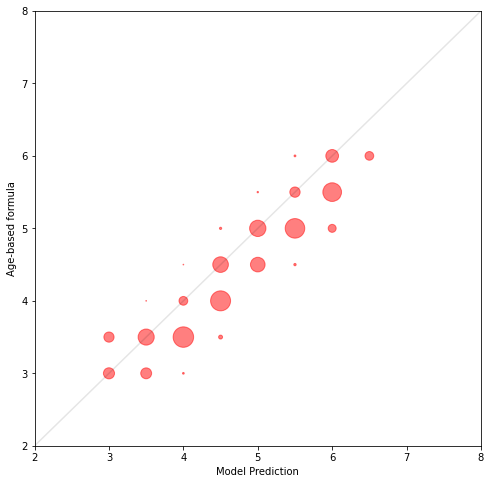

In [43]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((y_pred == x) & (y_test_old == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Model Prediction')
plt.ylabel('Age-based formula')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)

Text(0, 0.5, 'age-based formula')

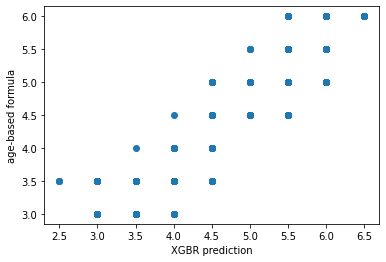

In [41]:
plt.scatter(y_pred, y_test_old)
plt.xlabel('XGBR prediction')
plt.ylabel('age-based formula')

# XGBr vs RF

In [ ]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test)

# RF model
rfr = pickle.load(open(f'result/size/acc1-0.595_acc3-0.963_RF_10fold/gridSearch','rb'))
y_rbr = rbr.predict(x_test_imputed).flatten()
#y_rbr = np.round(y_rbr * 2) / 2



In [3]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [7]:
# 0: age, 1: sex, 2: weight, 3: height, 4: cuffed
np.mean(np.isnan(x[:,3]))

0.024234768814993243

In [6]:
pd.DataFrame(x).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34042 entries, 0 to 34041
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       34042 non-null  float64
 1   1       34042 non-null  float64
 2   2       33603 non-null  float64
 3   3       33217 non-null  float64
 4   4       34042 non-null  float64
dtypes: float64(5)
memory usage: 1.3 MB


# 모델의 AGE 별 over/under estimate 비율

## Age 별 사용된 tube size (age-size plot)

### Age - size plot (uncuffed)

Text(0, 0.5, 'Size of uncuffed ETT used')

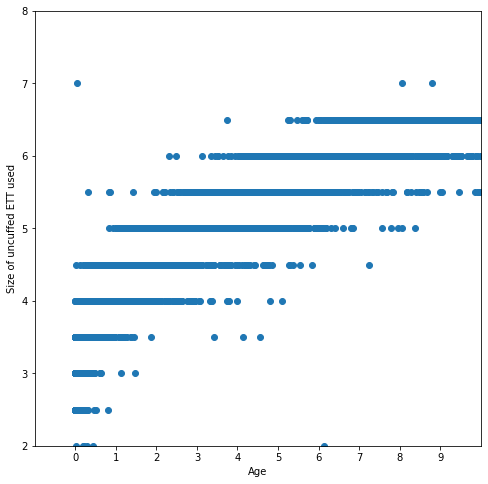

In [86]:
plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(x_test[:,0][~cuff_mask], y_test[~cuff_mask])
plt.xlabel('Age')
plt.ylabel('Size of uncuffed ETT used')


### Uncuffed

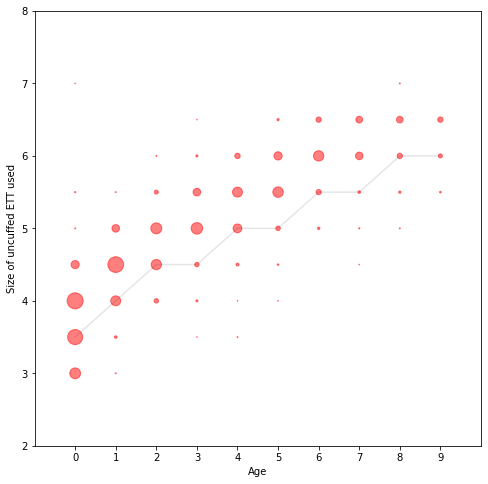

In [80]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])
cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 10, 1):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_age[~cuff_mask] == x) & (y_test[~cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age')
plt.ylabel('Size of uncuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([2,10], [4.5,6.5], 'k-', alpha=0.1) # 4 + age/4

### Cuffed

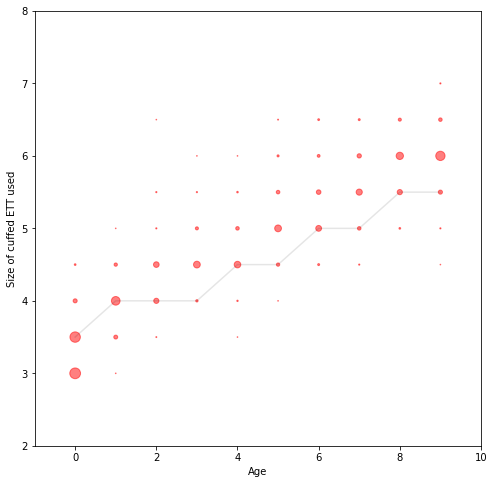

In [87]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 3.5) * 2) / 2 if x >= 2 else (3.0 if x < 1 else 3.5) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])

cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 10, 1):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_age[cuff_mask] == x) & (y_test[cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age')
plt.ylabel('Size of cuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
#plt.plot([2,10], [4,6], 'k-', alpha=0.1) # 3.5 + age/4
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)

In [ ]:
size_vals, cnt_vals = [], 
x_age = np.array([math.floor(x) for x in x_test[:,0]])
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

for i in range(1,10):
    size_vals.append(np.mean(y_test[x_age==i]))

## Height - size plot

In [90]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

(array([  29.,    2.,  184.,  845., 1217., 1347., 1314., 1139.,  644.,
          86.]),
 array([  1.  ,  16.68,  32.36,  48.04,  63.72,  79.4 ,  95.08, 110.76,
        126.44, 142.12, 157.8 ]),
 <BarContainer object of 10 artists>)

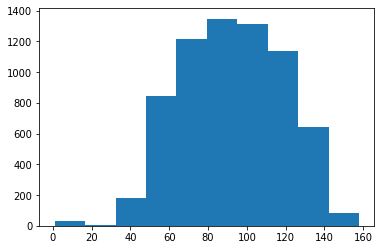

In [102]:
x_height = x_test_imputed[:,3]
x_height_ = x_height[x_height<200]
plt.hist(x_height_)

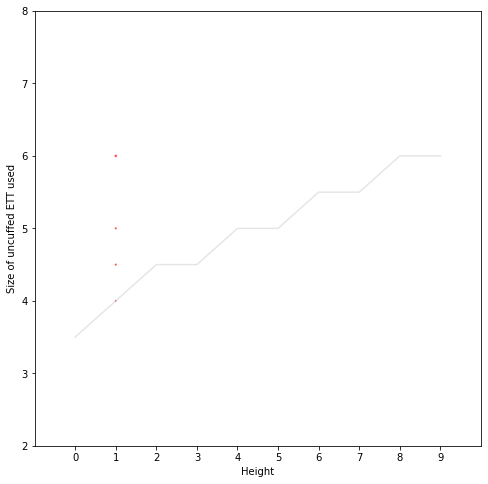

In [91]:
# Cole's formula 값
coles = [3.5, 4] + [math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4) for x in range(2,10)]
coles = np.array(coles)

xvals = []
yvals = []
cvals = []
cvals_old = []
x_age = np.array([math.floor(x) for x in x_test[:,0]])
cuff_mask = (x_test[:,4]==1)

for x in np.arange(0, 160, 10):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        
        cvals.append(sum((x_test_imputed[:,3][~cuff_mask] == x) & (y_test[~cuff_mask] == y)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
#cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xticks(np.arange(0,10))
plt.xlim(-1, 10)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Height')
plt.ylabel('Size of uncuffed ETT used')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([2,10], [4.5,6.5], 'k-', alpha=0.1) # 4 + age/4

## Age-based model

In [54]:
# 계산
x_age = np.array([math.floor(x) for x in x_test[:,0]])
xvals = []
yvals = []
cvals = []
p_under, p_over, p_cor = [], [], []
po_under, po_over, po_cor = [], [], []
age_bins = []
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

# 신생아
ag_mask = (x_test[:,0] < 1/12)
p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 영아
ag_mask = (1/12 <= x_test[:,0]) & (x_test[:,0] < 1)
p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 소아 (1~10살)
for x in np.arange(1, 10, 1):
    ag_mask = (x_age == x)
    p_over.append(np.mean(y_test_old[ag_mask] > y_test[ag_mask]))
    p_under.append(np.mean(y_test_old[ag_mask] < y_test[ag_mask]))
    p_cor.append(np.mean(y_test_old[ag_mask] == y_test[ag_mask]))
    age_bins.append(np.sum(ag_mask))
    
df_est = pd.DataFrame({'correct':p_cor, 'overestimate':p_over, 'underestimate':p_under, 'bins':age_bins}, index=age_interval)
df_est.round(2)

,correct,overestimate,underestimate,bins
0-1mo,0.47,0.42,0.11,242
1mo-1y,0.35,0.11,0.54,1644
1-2y,0.22,0.02,0.76,1032
2-3y,0.41,0.06,0.53,654
3-4y,0.09,0.02,0.90,571
4-5y,0.44,0.04,0.52,557
5-6y,0.11,0.01,0.88,569
6-7y,0.26,0.04,0.70,481
7-8y,0.10,0.02,0.88,372
8-9y,0.32,0.05,0.63,348


## XGBR

In [58]:
# xgbr 모델 예측값
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')

y_pred = xgbr.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2


# 계산
x_age = np.array([math.floor(x) for x in x_test[:,0]])
xvals = []
yvals = []
cvals = []
age_bins = []
p_under, p_over, p_cor = [], [], []
po_under, po_over, po_cor = [], [], []
age_interval = ['0-1mo','1mo-1y'] + [f'{i}-{i+1}y' for i in range(1,10)]

# 신생아
ag_mask = (x_test[:,0] < 1/12)
p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 영아
ag_mask = (1/12 <= x_test[:,0]) & (x_test[:,0] < 1)
p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
age_bins.append(np.sum(ag_mask))

# 소아 (1~10살)
for x in np.arange(1, 10, 1):
    ag_mask = (x_age == x)
    p_over.append(np.mean(y_pred[ag_mask] > y_test[ag_mask]))
    p_under.append(np.mean(y_pred[ag_mask] < y_test[ag_mask]))
    p_cor.append(np.mean(y_pred[ag_mask] == y_test[ag_mask]))
    age_bins.append(np.sum(ag_mask))
    
df_est = pd.DataFrame({'correct':p_cor, 'overestimate':p_over, 'underestimate':p_under, 'bins':age_bins}, index=age_interval)
print(f'XGBR model prediction')
df_est.round(2)

XGBR model prediction


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


,correct,overestimate,underestimate,bins
0-1mo,0.57,0.21,0.22,242
1mo-1y,0.66,0.17,0.18,1644
1-2y,0.63,0.19,0.18,1032
2-3y,0.58,0.18,0.24,654
3-4y,0.62,0.16,0.22,571
4-5y,0.53,0.25,0.22,557
5-6y,0.56,0.22,0.21,569
6-7y,0.56,0.22,0.22,481
7-8y,0.51,0.16,0.33,372
8-9y,0.56,0.21,0.23,348


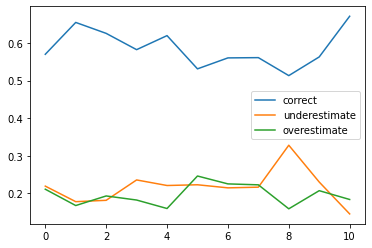

In [50]:
plt.plot(p_cor, label='correct')
plt.plot(p_under, label='underestimate')
plt.plot(p_over, label='overestimate')
plt.legend()